In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from scipy.sparse import hstack

# -------------------------------
# 📦 Load Data
# -------------------------------
def load_data():
    train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
    test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
    return {
        "X_train": train_df["clean_headline"].astype(str).reset_index(drop=True),
        "y_train": train_df["label_encoded"].reset_index(drop=True),
        "X_test": test_df["clean_headline"].astype(str).reset_index(drop=True),
        "y_test": test_df["label_encoded"].reset_index(drop=True),
    }

# -------------------------------
# 🔠 Vectorizers
# -------------------------------
def get_vectorized_data(vec_name, data):
    if vec_name == "TF-IDF BiChar":
        vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
        vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        X_train_vec = hstack([vec1.fit_transform(data["X_train"]), vec2.fit_transform(data["X_train"])])
        X_test_vec = hstack([vec1.transform(data["X_test"]), vec2.transform(data["X_test"])])
    else:
        vectorizer = {
            "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2), min_df=2),
            "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
        }[vec_name]
        X_train_vec = vectorizer.fit_transform(data["X_train"])
        X_test_vec = vectorizer.transform(data["X_test"])
    return X_train_vec, X_test_vec

# -------------------------------
# 🚀 Run SVM Tuning
# -------------------------------
def run_svm(X_train_vec, X_test_vec, y_train, y_test, vec_name):
    results = []
    C_vals = [0.01, 0.1, 1.0, 10.0]
    losses = ["hinge", "squared_hinge"]

    for C in C_vals:
        for loss in losses:
            dual = True if loss == "hinge" else False

            print(f"🔧 LinearSVC | Vec={vec_name} | C={C} | Loss={loss}")
            clf = LinearSVC(C=C, loss=loss, dual=dual, max_iter=10000)
            clf.fit(X_train_vec, y_train)
            y_pred = clf.predict(X_test_vec)
            f1 = f1_score(y_test, y_pred)

            try:
                scores = clf.decision_function(X_test_vec)
                auc = roc_auc_score(y_test, scores)
            except:
                auc = None

            # Save classification report
            report = classification_report(y_test, y_pred, output_dict=True)
            os.makedirs("models/svm/results", exist_ok=True)
            report_path = f"models/svm/results/svm_{vec_name.replace(' ', '_')}_C{C}_{loss}.csv"
            pd.DataFrame(report).transpose().to_csv(report_path)

            # Append summary
            results.append({
                "Model": "SVM",
                "Vec": vec_name,
                "C": C,
                "Loss": loss,
                "F1": round(f1, 4),
                "AUC": round(auc, 4) if auc is not None else None
            })

    return results

# -------------------------------
# 🧪 Run Tuning for All Vectorizers
# -------------------------------
data = load_data()
vectorizers = ["TF-IDF Bigrams", "Char TF-IDF", "TF-IDF BiChar"]
all_results = []

for vec_name in vectorizers:
    try:
        X_train_vec, X_test_vec = get_vectorized_data(vec_name, data)
    except Exception as e:
        print(f"❌ Skipping {vec_name}: {e}")
        continue

    all_results += run_svm(X_train_vec, X_test_vec, data["y_train"], data["y_test"], vec_name)

# -------------------------------
# 💾 Save Summary CSV
# -------------------------------
summary_df = pd.DataFrame(all_results)
summary_df.to_csv("models/svm/results/svm_summary.csv", index=False)
print("✅ SVM tuning summary saved to models/svm/results/svm_summary.csv")

🔧 LinearSVC | Vec=TF-IDF Bigrams | C=0.01 | Loss=hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=0.01 | Loss=squared_hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=0.1 | Loss=hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=0.1 | Loss=squared_hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=1.0 | Loss=hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=1.0 | Loss=squared_hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=10.0 | Loss=hinge
🔧 LinearSVC | Vec=TF-IDF Bigrams | C=10.0 | Loss=squared_hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=0.01 | Loss=hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=0.01 | Loss=squared_hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=0.1 | Loss=hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=0.1 | Loss=squared_hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=1.0 | Loss=hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=1.0 | Loss=squared_hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=10.0 | Loss=hinge
🔧 LinearSVC | Vec=Char TF-IDF | C=10.0 | Loss=squared_hinge
🔧 LinearSVC | Vec=TF-IDF BiChar | C=0.01 | Loss=hinge
🔧 LinearSVC | Vec=TF-IDF BiChar | 

In [2]:
print(summary_df)

   Model             Vec      C           Loss      F1     AUC
0    SVM  TF-IDF Bigrams   0.01          hinge  0.5422  0.9469
1    SVM  TF-IDF Bigrams   0.01  squared_hinge  0.8266  0.9581
2    SVM  TF-IDF Bigrams   0.10          hinge  0.8528  0.9655
3    SVM  TF-IDF Bigrams   0.10  squared_hinge  0.8976  0.9722
4    SVM  TF-IDF Bigrams   1.00          hinge  0.9122  0.9744
5    SVM  TF-IDF Bigrams   1.00  squared_hinge  0.9169  0.9746
6    SVM  TF-IDF Bigrams  10.00          hinge  0.9017  0.9661
7    SVM  TF-IDF Bigrams  10.00  squared_hinge  0.9036  0.9665
8    SVM     Char TF-IDF   0.01          hinge  0.6214  0.9333
9    SVM     Char TF-IDF   0.01  squared_hinge  0.8234  0.9493
10   SVM     Char TF-IDF   0.10          hinge  0.8497  0.9604
11   SVM     Char TF-IDF   0.10  squared_hinge  0.8895  0.9683
12   SVM     Char TF-IDF   1.00          hinge  0.9033  0.9720
13   SVM     Char TF-IDF   1.00  squared_hinge  0.9071  0.9733
14   SVM     Char TF-IDF  10.00          hinge  0.8994 

🏆 Best SVM → Vec: TF-IDF BiChar, C=1.0, Loss=squared_hinge, Dual=False


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/625176841.py:95: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/625176841.py:96: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("models/svm/plots/svm_top_words_plot.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


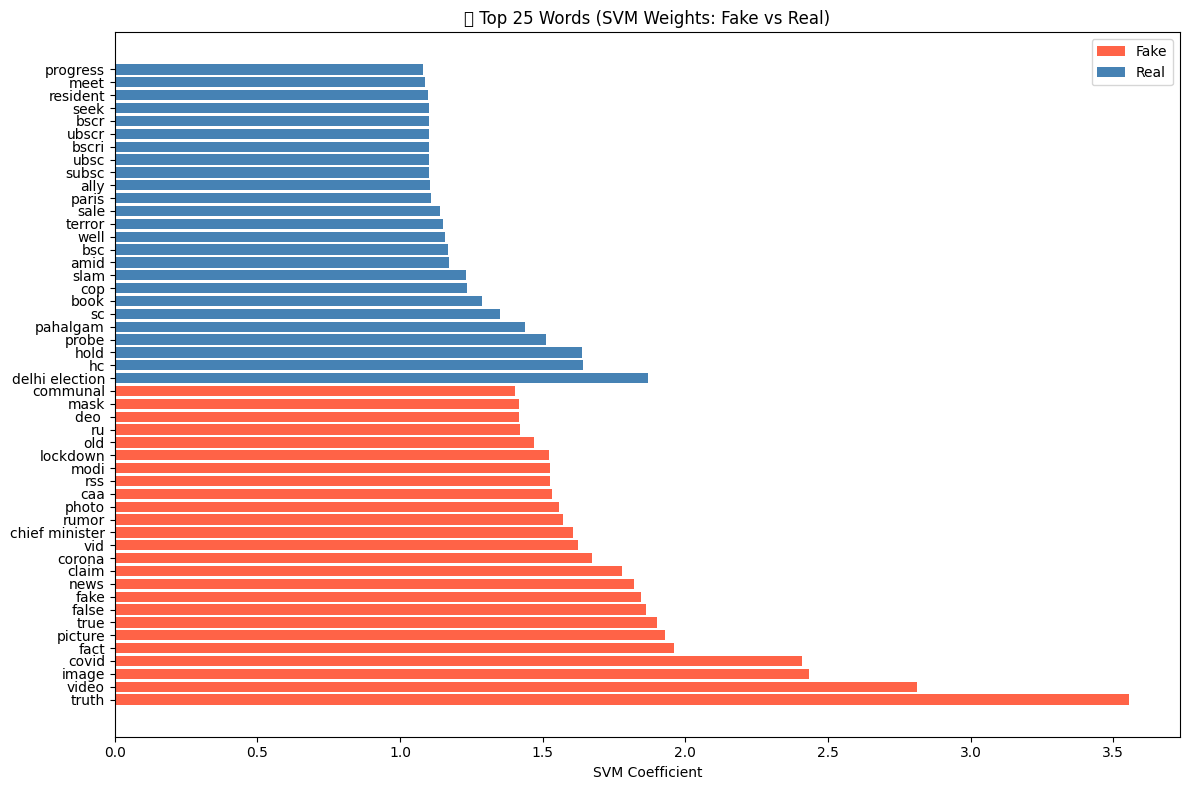

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from scipy.sparse import hstack

# -------------------------------
# 📂 Load Best Config
# -------------------------------
summary_df = pd.read_csv("models/svm/results/svm_summary.csv")
best_row = summary_df.sort_values(by="F1", ascending=False).iloc[0]

vec_name = best_row["Vec"]
C = best_row["C"]
loss = best_row["Loss"]
dual = True if loss == "hinge" else False

print(f"🏆 Best SVM → Vec: {vec_name}, C={C}, Loss={loss}, Dual={dual}")

# -------------------------------
# 📦 Load Data
# -------------------------------
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# 🔠 Vectorize Dynamically
# -------------------------------
if vec_name == "TF-IDF Bigrams":
    vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    vocab = vec.get_feature_names_out()

elif vec_name == "Char TF-IDF":
    vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    vocab = vec.get_feature_names_out()

elif vec_name == "TF-IDF BiChar":
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
    X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
    vocab = np.concatenate([vec1.get_feature_names_out(), vec2.get_feature_names_out()])

else:
    raise ValueError("❌ Unknown vectorizer!")

# -------------------------------
# 🧠 Train SVM + Extract Features
# -------------------------------
top_k = 25

clf = LinearSVC(C=C, loss=loss, dual=dual, max_iter=10000)
clf.fit(X_train_vec, y_train)
coef = clf.coef_[0]

top_fake_idx = np.argsort(coef)[-top_k:][::-1]
top_real_idx = np.argsort(coef)[:top_k]

top_features = pd.DataFrame({
    "Fake_Indicators": vocab[top_fake_idx],
    "Fake_Weights": coef[top_fake_idx],
    "Real_Indicators": vocab[top_real_idx],
    "Real_Weights": coef[top_real_idx]
})

# -------------------------------
# 💾 Save Results
# -------------------------------
os.makedirs("models/svm/results", exist_ok=True)
os.makedirs("models/svm/plots", exist_ok=True)
os.makedirs("models/svm/interpretability", exist_ok=True)

top_features.to_csv("models/svm/interpretability/svm_top_words.csv", index=False)

# -------------------------------
# 📊 Plot
# -------------------------------
plt.figure(figsize=(12, 8))
plt.barh(top_features["Fake_Indicators"], top_features["Fake_Weights"], color="tomato", label="Fake")
plt.barh(top_features["Real_Indicators"], -top_features["Real_Weights"], color="steelblue", label="Real")
plt.xlabel("SVM Coefficient")
plt.title("🔍 Top 25 Words (SVM Weights: Fake vs Real)")
plt.legend()
plt.tight_layout()
plt.savefig("models/svm/plots/svm_top_words_plot.png")
plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/3003848903.py:53: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.savefig("models/svm/plots/svm_confusion_matrix.png", bbox_inches="tight")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


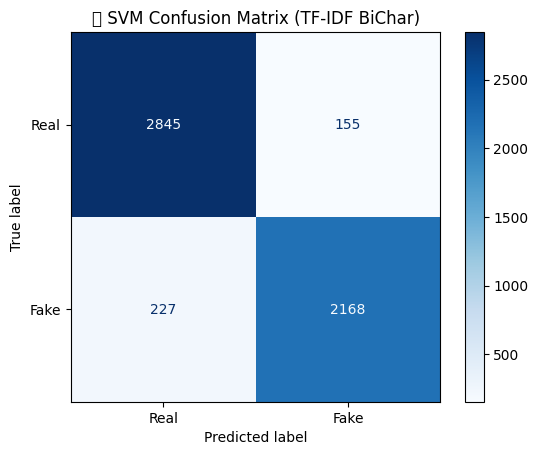

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from scipy.sparse import hstack

# -------------------------------
# 📦 Load Test Data
# -------------------------------
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# 🔠 Best Vectorizer: TF-IDF BiChar
# -------------------------------
vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)

train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]

X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])

# -------------------------------
# 🚀 Train Best Model
# -------------------------------
clf = LinearSVC(C=1.0, loss='squared_hinge', dual=False, max_iter=10000)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

# -------------------------------
# 🧾 Save classification report
# -------------------------------
report = classification_report(y_test, y_pred, output_dict=True)
os.makedirs("models/svm/results", exist_ok=True)
pd.DataFrame(report).transpose().to_csv("models/svm/results/svm_test_report.csv")

# -------------------------------
# 📊 Confusion Matrix Plot
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap="Blues")
plt.title("🧩 SVM Confusion Matrix (TF-IDF BiChar)")
os.makedirs("models/svm/plots", exist_ok=True)
plt.savefig("models/svm/plots/svm_confusion_matrix.png", bbox_inches="tight")
plt.show()

In [11]:
import os
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# -------------------------------
# 📦 Load Best Config
# -------------------------------
summary_df = pd.read_csv("models/svm/results/svm_summary.csv")
best_row = summary_df.sort_values("F1", ascending=False).iloc[0]
vec_name = best_row["Vec"]
C = float(best_row["C"])
loss = best_row["Loss"]
dual = False if loss == "squared_hinge" else True

print(f"🏆 Best SVM → Vec: {vec_name}, C={C}, Loss={loss}, Dual={dual}")

# -------------------------------
# 📂 Load Data
# -------------------------------
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]

# -------------------------------
# 🔠 Vectorizer Logic
# -------------------------------
if vec_name == "TF-IDF BiChar":
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
    X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])
else:
    vectorizer = {
        "TF-IDF Bigrams": TfidfVectorizer(ngram_range=(1, 2), min_df=2),
        "Char TF-IDF": TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    }[vec_name]
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

# -------------------------------
# 🤖 Train & Predict
# -------------------------------
clf = LinearSVC(C=C, loss=loss, dual=dual, max_iter=10000)
clf.fit(X_train_vec, y_train)
y_pred = clf.predict(X_test_vec)

# -------------------------------
# 💾 Save Predictions
# -------------------------------
pred_df = pd.DataFrame({"predicted": y_pred})
os.makedirs("models/svm/results", exist_ok=True)
pred_df.to_csv("models/svm/results/svm_best_predictions.csv", index=False)

print("✅ Saved best SVM predictions to models/svm/results/svm_best_predictions.csv")

🏆 Best SVM → Vec: TF-IDF BiChar, C=1.0, Loss=squared_hinge, Dual=False
✅ Saved best SVM predictions to models/svm/results/svm_best_predictions.csv


✅ False Positives: 554 | False Negatives: 627


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/2531712814.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/2531712814.py:58: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/2531712814.py:60: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_PATH}/{fname}.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


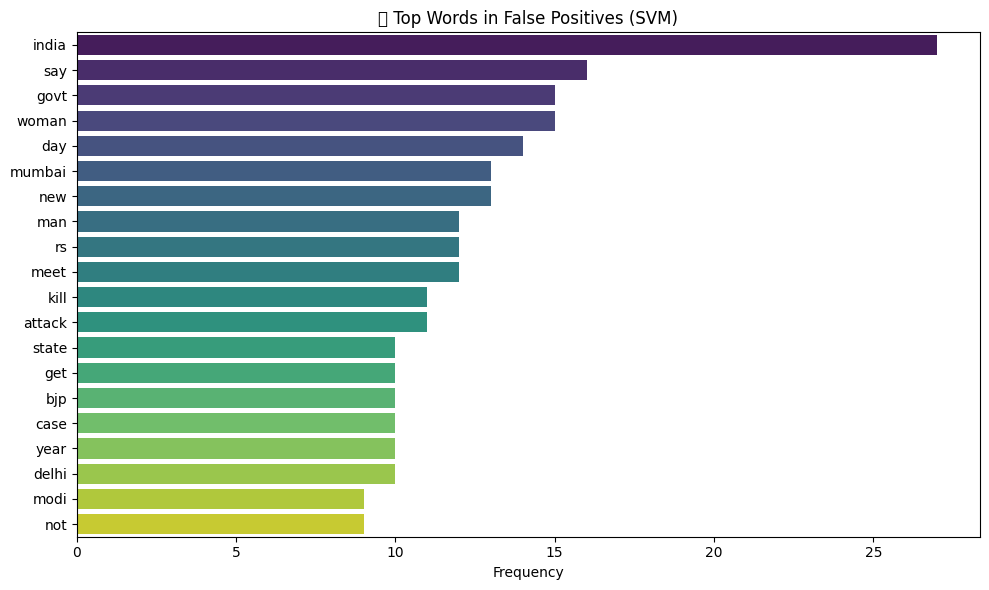

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/2531712814.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/2531712814.py:58: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/2531712814.py:60: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_PATH}/{fname}.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


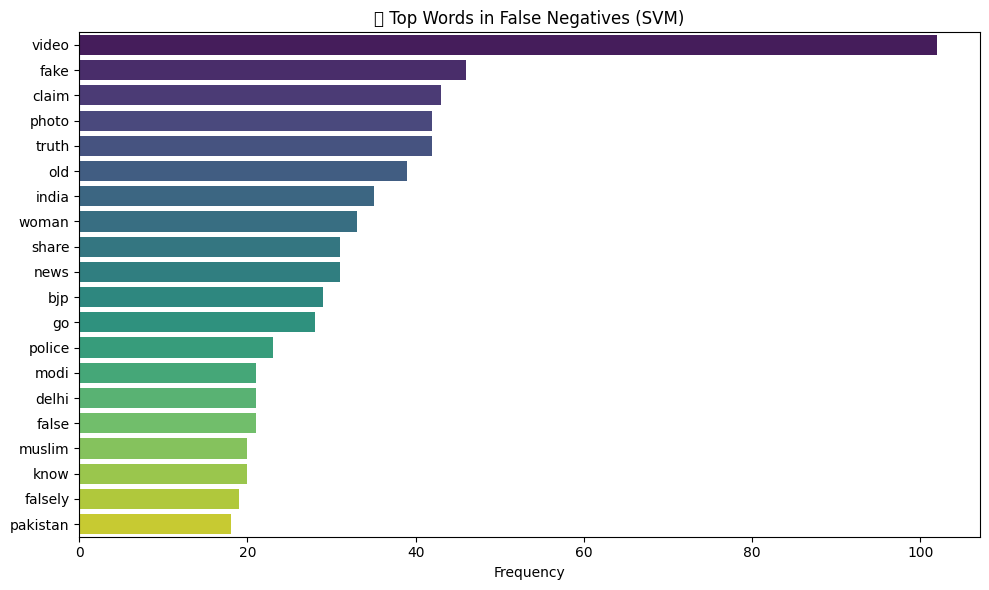

In [13]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📂 Paths & Config
# -------------------------------
PRED_PATH = "models/svm/results/svm_best_predictions.csv"
DATA_PATH = "data/processed_test.csv"
ERROR_PATH = "models/svm/error_inspection"
PLOT_PATH = "models/svm/plots"

# -------------------------------
# 📦 Load Data
# -------------------------------
df_preds = pd.read_csv(PRED_PATH)
df_test = pd.read_csv(DATA_PATH)
df = pd.concat([df_test.reset_index(drop=True), df_preds["predicted"]], axis=1)

# -------------------------------
# 🔍 Separate FP/FN
# -------------------------------
df["true_label"] = df["label_encoded"]
df["fp"] = (df["true_label"] == 0) & (df["predicted"] == 1)
df["fn"] = (df["true_label"] == 1) & (df["predicted"] == 0)

fp_df = df[df["fp"]]
fn_df = df[df["fn"]]

os.makedirs(ERROR_PATH, exist_ok=True)
fp_df.to_csv(f"{ERROR_PATH}/svm_fp.csv", index=False)
fn_df.to_csv(f"{ERROR_PATH}/svm_fn.csv", index=False)

print(f"✅ False Positives: {len(fp_df)} | False Negatives: {len(fn_df)}")

# -------------------------------
# 🧠 Word Frequency Analysis
# -------------------------------
def get_word_freq(texts):
    clean_texts = texts.dropna().astype(str)
    words = " ".join(clean_texts).split()
    return Counter(words).most_common(20)

fp_words = get_word_freq(fp_df["clean_headline"])
fn_words = get_word_freq(fn_df["clean_headline"])

# -------------------------------
# 📊 Plot Word Frequencies
# -------------------------------
def plot_freq(freqs, title, fname):
    words, counts = zip(*freqs)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    os.makedirs(PLOT_PATH, exist_ok=True)
    plt.savefig(f"{PLOT_PATH}/{fname}.png")
    plt.show()

plot_freq(fp_words, "🔍 Top Words in False Positives (SVM)", "svm_fp_words")
plot_freq(fn_words, "🔍 Top Words in False Negatives (SVM)", "svm_fn_words")

In [14]:
import os
import joblib
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# -------------------------------
# 📄 Load Best Config
# -------------------------------
summary = pd.read_csv("models/svm/results/svm_summary.csv")
best = summary.sort_values(by="F1", ascending=False).iloc[0]

vec_name = best["Vec"]
C = float(best["C"])
loss = best["Loss"]
dual = True if loss == "hinge" else False

print(f"🏆 Best Config → Vec: {vec_name}, C: {C}, loss: {loss}, dual: {dual}")

# -------------------------------
# 📦 Load Training Data
# -------------------------------
df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = df["clean_headline"].astype(str)
y_train = df["label_encoded"]

# -------------------------------
# 🔠 Vectorize Based on Best Vec
# -------------------------------
if vec_name == "TF-IDF Bigrams":
    vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    vectorizers = [vec]
elif vec_name == "Char TF-IDF":
    vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = vec.fit_transform(X_train)
    vectorizers = [vec]
elif vec_name == "TF-IDF BiChar":
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
    vectorizers = [vec1, vec2]
else:
    raise ValueError("❌ Unknown vectorizer name!")

# -------------------------------
# ✅ Train Best Model
# -------------------------------
clf = LinearSVC(C=C, loss=loss, dual=dual, max_iter=10000)
clf.fit(X_train_vec, y_train)

# -------------------------------
# 💾 Save Model & Vectorizers
# -------------------------------
os.makedirs("models/svm/artifacts", exist_ok=True)
joblib.dump(clf, "models/svm/artifacts/best_model.pkl")
for i, v in enumerate(vectorizers):
    name = "word_vectorizer" if i == 0 else "char_vectorizer"
    joblib.dump(v, f"models/svm/artifacts/{name}.pkl")

print("✅ Saved best SVM model and vectorizer(s) to disk.")

🏆 Best Config → Vec: TF-IDF BiChar, C: 1.0, loss: squared_hinge, dual: False
✅ Saved best SVM model and vectorizer(s) to disk.


In [15]:
import os
import joblib
import pandas as pd
import numpy as np
from lime.lime_text import LimeTextExplainer
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
MODEL_PATH = "models/svm/artifacts/best_model.pkl"
WORD_VEC_PATH = "models/svm/artifacts/word_vectorizer.pkl"
CHAR_VEC_PATH = "models/svm/artifacts/char_vectorizer.pkl"
DATA_PATH = "data/processed_test.csv"
PRED_PATH = "models/svm/results/svm_best_predictions.csv"
LIME_DIR = "models/svm/interpretability/lime_fp_fn"

# -------------------------------
# 📦 Load Model + Vectorizer(s)
# -------------------------------
clf = joblib.load(MODEL_PATH)
word_vec = joblib.load(WORD_VEC_PATH)
char_vec = None
if os.path.exists(CHAR_VEC_PATH):
    char_vec = joblib.load(CHAR_VEC_PATH)

# -------------------------------
# 📦 Load Predictions + Labels
# -------------------------------
df_preds = pd.read_csv(PRED_PATH)
df_test = pd.read_csv(DATA_PATH)
df = pd.concat([df_test.reset_index(drop=True), df_preds["predicted"]], axis=1)
df["true_label"] = df["label_encoded"]
df["fp"] = (df["true_label"] == 0) & (df["predicted"] == 1)
df["fn"] = (df["true_label"] == 1) & (df["predicted"] == 0)
df["correct"] = df["true_label"] == df["predicted"]

# -------------------------------
# 🧠 Sample Selection
# -------------------------------
fp_samples = df[df["fp"]].sample(5, random_state=42)
fn_samples = df[df["fn"]].sample(5, random_state=42)
correct_sample = df[df["correct"]].sample(1, random_state=42)

samples = {
    "fp": fp_samples,
    "fn": fn_samples,
    "correct": correct_sample
}

# -------------------------------
# 🔍 LIME Setup
# -------------------------------
explainer = LimeTextExplainer(class_names=["Real", "Fake"])
os.makedirs(LIME_DIR, exist_ok=True)

def vectorize_text(texts):
    X1 = word_vec.transform(texts)
    if char_vec:
        X2 = char_vec.transform(texts)
        return hstack([X1, X2])
    return X1

def predict_fn(texts):
    vecs = vectorize_text(texts)
    scores = clf.decision_function(vecs)
    # Ensure binary decision output
    if len(scores.shape) == 1:
        return np.column_stack([1 - scores, scores])
    return scores

def run_lime(group, df_group):
    for i, row in enumerate(df_group.itertuples()):
        exp = explainer.explain_instance(
            row.clean_headline,
            predict_fn,
            num_features=10
        )
        fname = f"{LIME_DIR}/lime_svm_{group}_{i}.html"
        exp.save_to_file(fname)
        print(f"✅ Saved: {fname}")

for group, sample_df in samples.items():
    run_lime(group, sample_df)

✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fp_0.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fp_1.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fp_2.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fp_3.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fp_4.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fn_0.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fn_1.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fn_2.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fn_3.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_fn_4.html
✅ Saved: models/svm/interpretability/lime_fp_fn/lime_svm_correct_0.html


In [ ]:
import os
import pandas as pd

# -------------------------------
# 📂 Paths
# -------------------------------
FP_PATH = "models/svm/error_inspection/svm_fp.csv"
FN_PATH = "models/svm/error_inspection/svm_fn.csv"
OUT_PATH = "models/svm/error_inspection/svm_fp_fn_annotated.csv"

# -------------------------------
# 📦 Load Data
# -------------------------------
fp_df = pd.read_csv(FP_PATH)
fn_df = pd.read_csv(FN_PATH)

fp_df["error_type"] = "unknown"
fn_df["error_type"] = "unknown"
fp_df["mistake_type"] = "FP"
fn_df["mistake_type"] = "FN"

errors_df = pd.concat([fp_df, fn_df], ignore_index=True).reset_index(drop=True)

# -------------------------------
# 🏷️ Manual Error Tagging
# Add your own index–label mapping below
# Example: 12: "satire", 34: "ambiguous", etc.
manual_tags = {
    12: "satire",
    31: "clickbait",
    50: "factual_overlap",
    77: "ambiguous",
    122: "named_entity_confusion"
}

# Apply tagging
for idx, tag in manual_tags.items():
    if idx < len(errors_df):
        errors_df.at[idx, "error_type"] = tag

# -------------------------------
# 💾 Save
# -------------------------------
os.makedirs(os.path.dirname(OUT_PATH), exist_ok=True)
errors_df.to_csv(OUT_PATH, index=False)
print(f"✅ Saved tagged FP/FN to: {OUT_PATH}")

# Optional: Show tag distribution
print("\n🔍 Error Type Distribution:")
print(errors_df["error_type"].value_counts())

✅ Saved category metrics to svm_per_category_metrics.csv


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/846899439.py:80: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/846899439.py:82: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/svm_per_category_metrics_barplot.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


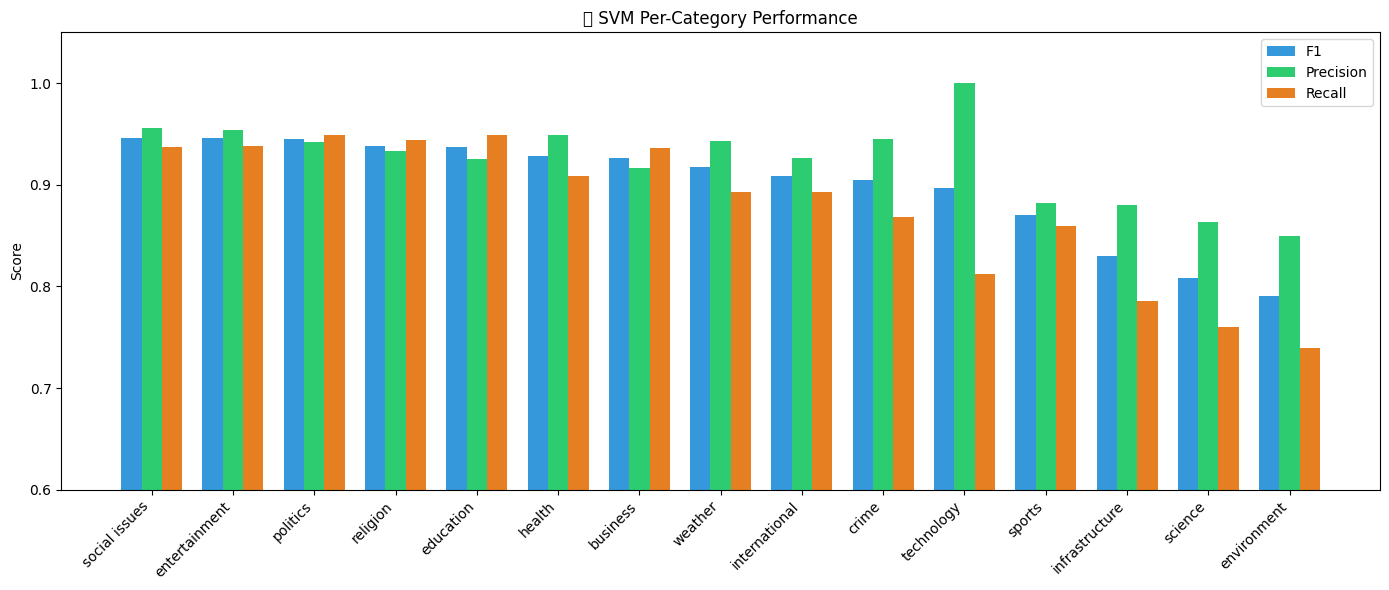

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/846899439.py:97: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/846899439.py:98: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/svm_per_category_metrics_heatmap.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


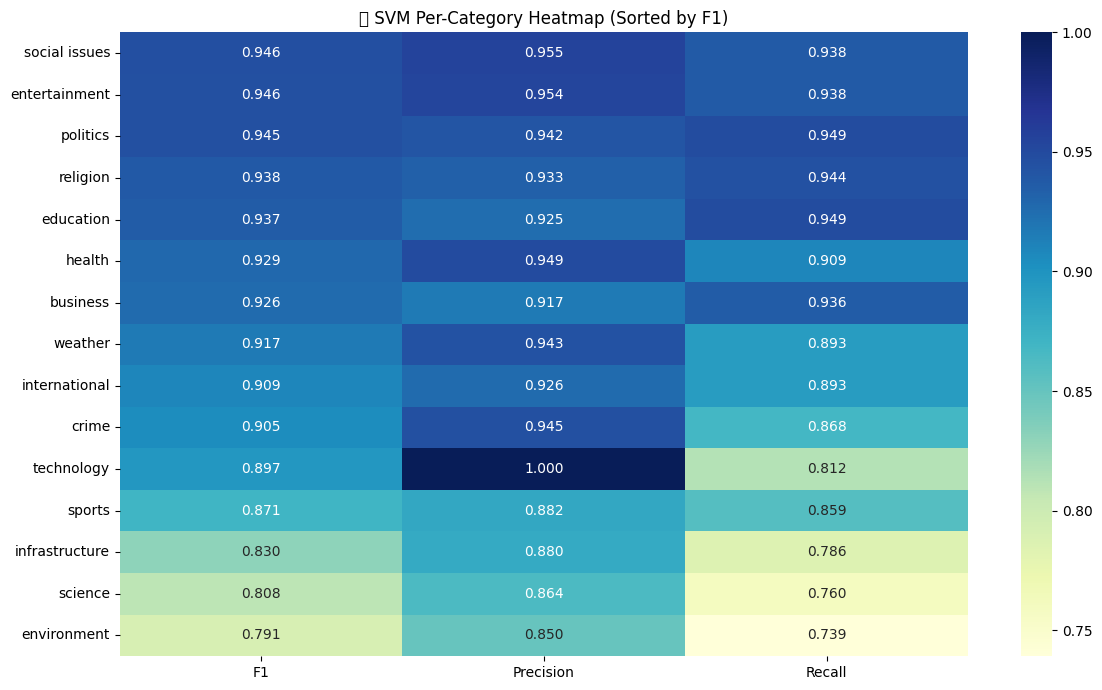

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/846899439.py:117: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_55721/846899439.py:118: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_DIR}/svm_per_category_f1_barplot_ci.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


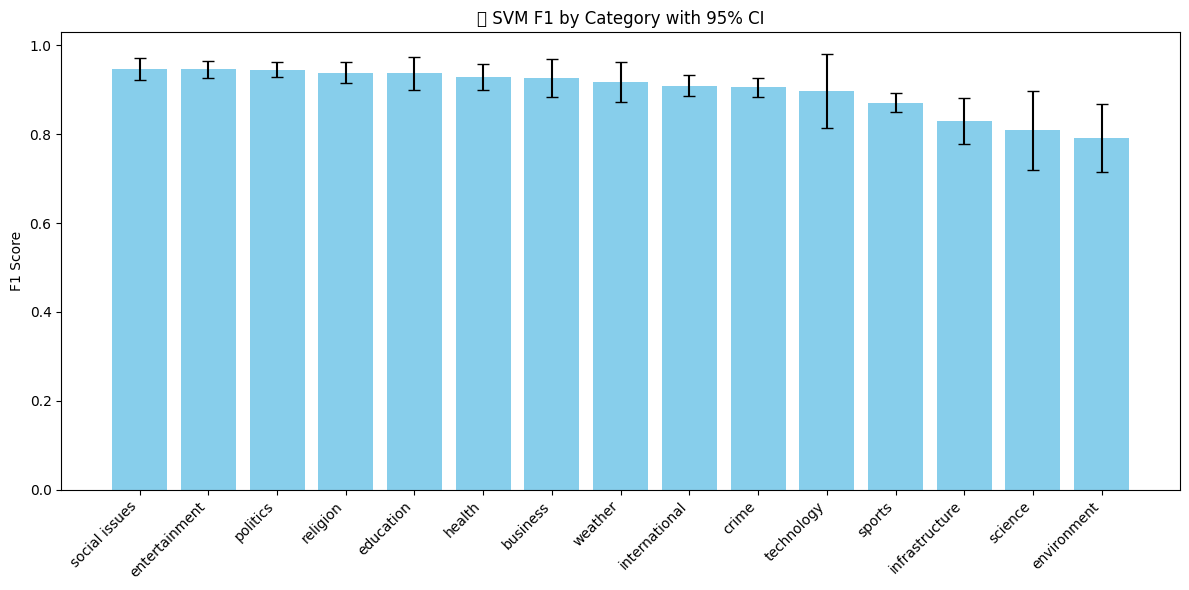

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/svm/results/svm_best_predictions.csv"
DATA_PATH = "data/processed_test.csv"
SAVE_DIR = "models/svm/results"
PLOT_DIR = "models/svm/plots"

# -------------------------------
# 📦 Load & Align Data
# -------------------------------
df_preds = pd.read_csv(PRED_PATH)
df_test = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded", "category"])

# Reset index to ensure proper alignment
df_test = df_test.reset_index(drop=True)
df_preds = df_preds.reset_index(drop=True)

# Sanity check
assert len(df_test) == len(df_preds), "Mismatch between test samples and predictions!"

# Merge
df = pd.concat([df_test, df_preds["predicted"]], axis=1)
df = df.dropna(subset=["predicted"])  # Drop any NaNs if still present
df["predicted"] = df["predicted"].astype(int)

# -------------------------------
# 🧮 Compute Per-Category Metrics
# -------------------------------
results = []
for cat in sorted(df["category"].unique()):
    cat_df = df[df["category"] == cat]
    y_true = cat_df["label_encoded"]
    y_pred = cat_df["predicted"]

    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)

    results.append({
        "Category": cat,
        "Samples": len(cat_df),
        "F1": round(f1, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4)
    })

df_metrics = pd.DataFrame(results).sort_values("F1", ascending=False)

# -------------------------------
# 💾 Save CSV
# -------------------------------
os.makedirs(SAVE_DIR, exist_ok=True)
df_metrics.to_csv(f"{SAVE_DIR}/svm_per_category_metrics.csv", index=False)
print("✅ Saved category metrics to svm_per_category_metrics.csv")

# -------------------------------
# 📊 Visualization 1: Barplot
# -------------------------------
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = np.arange(len(df_metrics))

plt.bar(x, df_metrics["F1"], width=bar_width, label="F1", color="#3498db")
plt.bar(x + bar_width, df_metrics["Precision"], width=bar_width, label="Precision", color="#2ecc71")
plt.bar(x + 2*bar_width, df_metrics["Recall"], width=bar_width, label="Recall", color="#e67e22")

plt.xticks(x + bar_width, df_metrics["Category"], rotation=45, ha="right")
plt.ylabel("Score")
plt.ylim(0.6, 1.05)
plt.title("📊 SVM Per-Category Performance")
plt.legend()
plt.tight_layout()
os.makedirs(PLOT_DIR, exist_ok=True)
plt.savefig(f"{PLOT_DIR}/svm_per_category_metrics_barplot.png")
plt.show()

# -------------------------------
# 📉 Visualization 2: Heatmap
# -------------------------------
plt.figure(figsize=(12, 7))
sns.heatmap(
    df_metrics[["F1", "Precision", "Recall"]],
    annot=True,
    cmap="YlGnBu",
    fmt=".3f",
    yticklabels=df_metrics["Category"]
)
plt.title("📊 SVM Per-Category Heatmap (Sorted by F1)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_per_category_metrics_heatmap.png")
plt.show()

# -------------------------------
# 🧮 Add Confidence Intervals (Optional)
# -------------------------------
def compute_se(p, n):
    return 1.96 * np.sqrt(p * (1 - p) / n)

df_metrics["F1_SE"] = compute_se(df_metrics["F1"], df_metrics["Samples"])

# -------------------------------
# 📉 Visualization 3: F1 ± CI
# -------------------------------
plt.figure(figsize=(12, 6))
plt.bar(df_metrics["Category"], df_metrics["F1"], yerr=df_metrics["F1_SE"], capsize=4, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1 Score")
plt.title("📊 SVM F1 by Category with 95% CI")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_per_category_f1_barplot_ci.png")
plt.show()

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/1544409624.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/1544409624.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(SAVE_PATH)
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


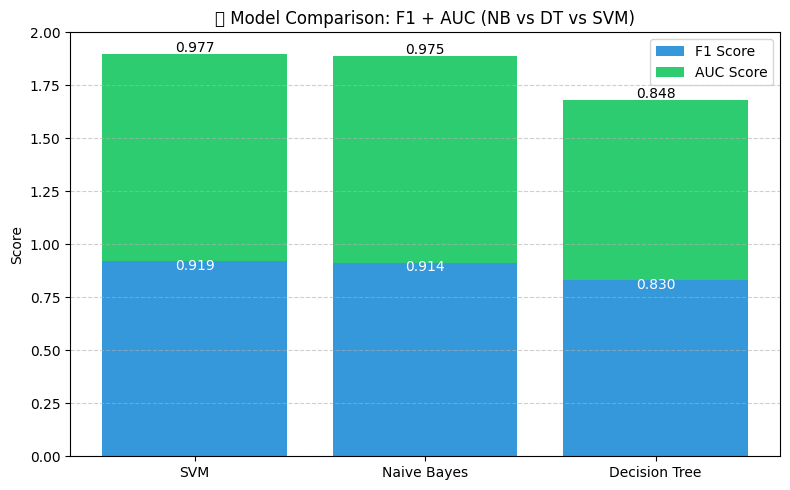

✅ Saved comparison plot to: models/svm/plots/nb_dt_svm_comparison.png


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 📂 Paths
# -------------------------------
NB_DT_PATH = "models/results/classical_models_tuned/research_nb_dt_summary.csv"
SVM_PATH = "models/svm/results/svm_summary.csv"
SAVE_PATH = "models/svm/plots/nb_dt_svm_comparison.png"

# -------------------------------
# 📦 Load and Extract Best per Model
# -------------------------------
nb_dt = pd.read_csv(NB_DT_PATH)
svm = pd.read_csv(SVM_PATH)

best_nb = nb_dt[nb_dt["Model"] == "NaiveBayes"].sort_values("F1", ascending=False).iloc[0]
best_dt = nb_dt[nb_dt["Model"] == "DecisionTree"].sort_values("F1", ascending=False).iloc[0]
best_svm = svm.sort_values("F1", ascending=False).iloc[0]

# -------------------------------
# 🧮 Prepare Data Sorted by F1
# -------------------------------
data = [
    ("Naive Bayes", best_nb["F1"], best_nb["AUC"]),
    ("Decision Tree", best_dt["F1"], best_dt["AUC"]),
    ("SVM", best_svm["F1"], best_svm["AUC"])
]
data.sort(key=lambda x: x[1], reverse=True)  # Sort by F1

models, f1_scores, auc_scores = zip(*data)

# -------------------------------
# 📈 Plot
# -------------------------------
plt.figure(figsize=(8, 5))
bars1 = plt.bar(models, f1_scores, label="F1 Score", color="#3498db")
bars2 = plt.bar(models, auc_scores, bottom=f1_scores, label="AUC Score", color="#2ecc71")

# 🔢 Add annotations
for bar, f1 in zip(bars1, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, f1 - 0.04, f"{f1:.3f}", ha='center', color="white", fontsize=10)

for bar, f1, auc in zip(bars2, f1_scores, auc_scores):
    plt.text(bar.get_x() + bar.get_width()/2, f1 + auc + 0.01, f"{auc:.3f}", ha='center', color="black", fontsize=10)

# 📊 Styling
plt.ylabel("Score")
plt.title("📊 Model Comparison: F1 + AUC (NB vs DT vs SVM)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, 2.0)
plt.legend()
plt.tight_layout()

# 💾 Save
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
plt.savefig(SAVE_PATH)
plt.show()

print(f"✅ Saved comparison plot to: {SAVE_PATH}")

✅ SHAP summary plot saved to models/svm/interpretability/shap_summary_plot.png


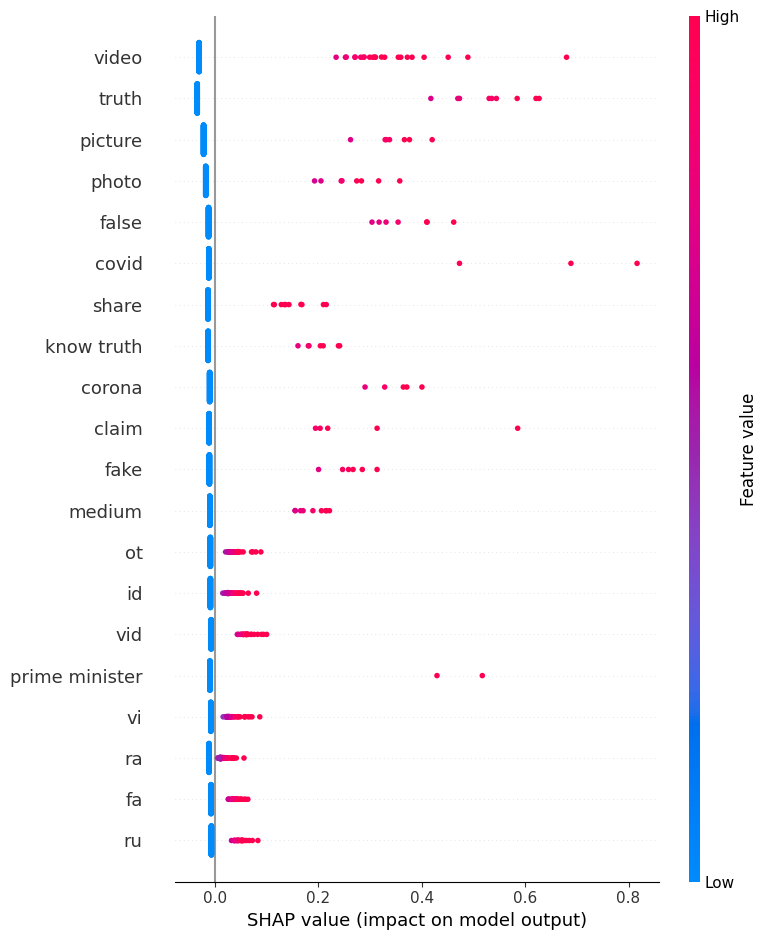

In [1]:
import shap
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
MODEL_PATH = "models/svm/artifacts/best_model.pkl"
WORD_VEC_PATH = "models/svm/artifacts/word_vectorizer.pkl"
CHAR_VEC_PATH = "models/svm/artifacts/char_vectorizer.pkl"
TRAIN_PATH = "data/processed_train.csv"
SAVE_DIR = "models/svm/interpretability"

os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data & Artifacts
# -------------------------------
model = joblib.load(MODEL_PATH)
vec_word = joblib.load(WORD_VEC_PATH)
vec_char = joblib.load(CHAR_VEC_PATH)

df = pd.read_csv(TRAIN_PATH).dropna(subset=["clean_headline", "label_encoded"])
X = df["clean_headline"].astype(str).reset_index(drop=True)
y = df["label_encoded"]

# -------------------------------
# 🧠 Vectorize + Subsample
# -------------------------------
X_word = vec_word.transform(X)
X_char = vec_char.transform(X)
X_combined = hstack([X_word, X_char])

# SHAP expects dense input, so take a small sample
sample_size = 200
X_dense = X_combined[:sample_size].toarray()

# Combine feature names
feature_names = list(vec_word.get_feature_names_out()) + list(vec_char.get_feature_names_out())

# -------------------------------
# ⚡ SHAP: Explainer
# -------------------------------
explainer = shap.Explainer(model, X_dense, feature_names=feature_names)
shap_values = explainer(X_dense)

# -------------------------------
# 📊 Save Summary Plot
# -------------------------------
plt.figure()
shap.summary_plot(shap_values, X_dense, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/shap_summary_plot.png")
print(f"✅ SHAP summary plot saved to {SAVE_DIR}/shap_summary_plot.png")

✅ Saved fairness metrics to models/svm/results/svm_fairness_metrics.csv


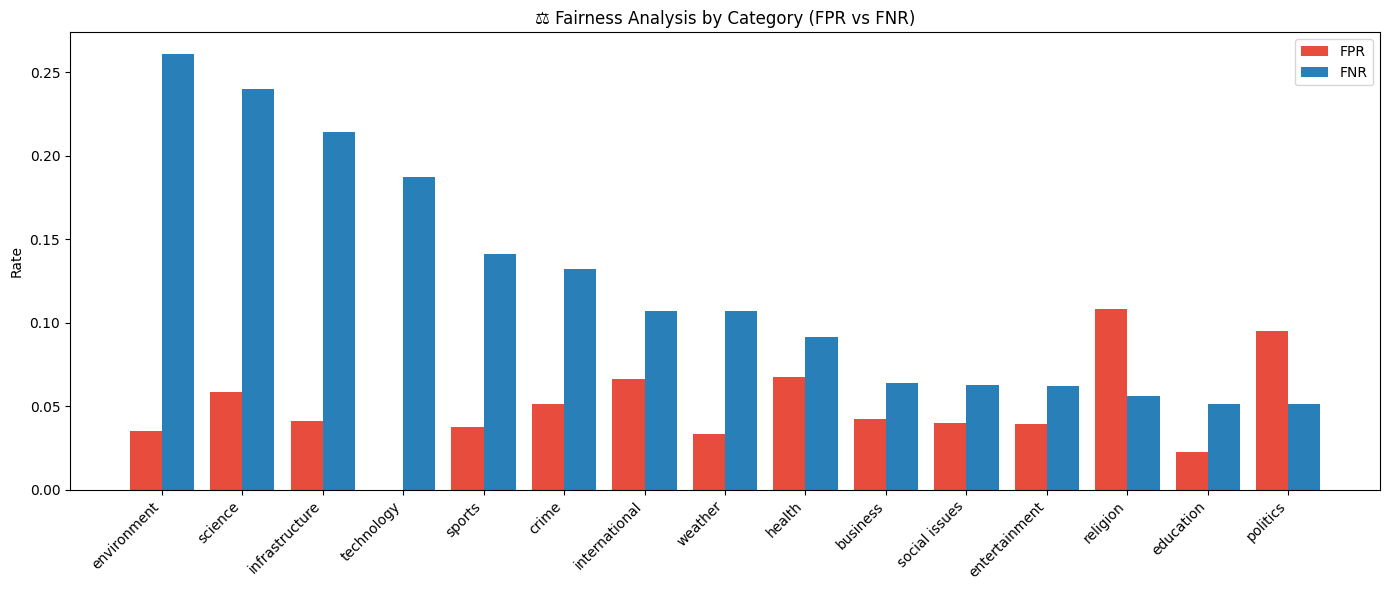

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_PATH = "data/processed_test.csv"
PRED_PATH = "models/svm/results/svm_best_predictions.csv"
FAIRNESS_PATH = "models/svm/results/svm_fairness_metrics.csv"
PLOT_PATH = "models/svm/plots"

os.makedirs(PLOT_PATH, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
df_true = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded", "category"])
df_pred = pd.read_csv(PRED_PATH)
df = pd.concat([df_true.reset_index(drop=True), df_pred["predicted"]], axis=1)
df["predicted"] = df["predicted"].astype(int)

# -------------------------------
# 🔍 Compute Per-Category Fairness Metrics
# -------------------------------
results = []

for cat in sorted(df["category"].unique()):
    sub = df[df["category"] == cat]
    y_true = sub["label_encoded"]
    y_pred = sub["predicted"]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    support = len(sub)

    results.append({
        "Category": cat,
        "Support": support,
        "False_Positive_Rate": round(fpr, 4),
        "False_Negative_Rate": round(fnr, 4),
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "TP": tp
    })

df_fair = pd.DataFrame(results).sort_values("False_Negative_Rate", ascending=False)
df_fair.to_csv(FAIRNESS_PATH, index=False)
print(f"✅ Saved fairness metrics to {FAIRNESS_PATH}")

# -------------------------------
# 📊 Plot FPR + FNR
# -------------------------------
plt.figure(figsize=(14, 6))
x = np.arange(len(df_fair))
bar_width = 0.4

plt.bar(x - bar_width/2, df_fair["False_Positive_Rate"], width=bar_width, label="FPR", color="#e74c3c")
plt.bar(x + bar_width/2, df_fair["False_Negative_Rate"], width=bar_width, label="FNR", color="#2980b9")
plt.xticks(x, df_fair["Category"], rotation=45, ha="right")
plt.ylabel("Rate")
plt.title("⚖️ Fairness Analysis by Category (FPR vs FNR)")
plt.legend()
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/svm_fairness_barplot.png")
plt.show()

In [3]:
import os
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
os.makedirs("models/svm/results", exist_ok=True)
SAVE_PATH = "models/svm/results/svm_feature_ablation.csv"

# -------------------------------
# 📦 Load Data
# -------------------------------
df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
X = df["clean_headline"].astype(str)
y = df["label_encoded"]

# Stratified small sample for reproducibility
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=5000, stratify=y, random_state=42)

# -------------------------------
# 🧪 Define Vectorizers
# -------------------------------
word_vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
char_vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)

X_word = word_vec.fit_transform(X_train)
X_char = char_vec.fit_transform(X_train)

X_val_word = word_vec.transform(X_val)
X_val_char = char_vec.transform(X_val)

# -------------------------------
# 🔍 Run Ablation
# -------------------------------
results = []

def run_svm(X_train_vec, X_val_vec, name):
    clf = LinearSVC(C=1.0, loss="squared_hinge", dual=False, max_iter=10000)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_val_vec)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, clf.decision_function(X_val_vec))
    results.append({
        "Setting": name,
        "F1": round(f1, 4),
        "AUC": round(auc, 4)
    })

# A. Full BiChar = Word + Char
X_both = hstack([X_word, X_char])
X_val_both = hstack([X_val_word, X_val_char])
run_svm(X_both, X_val_both, "Word + Char")

# B. Only Word N-Grams
run_svm(X_word, X_val_word, "Only Word")

# C. Only Char N-Grams
run_svm(X_char, X_val_char, "Only Char")

# -------------------------------
# 💾 Save Results
# -------------------------------
df_results = pd.DataFrame(results)
df_results.to_csv(SAVE_PATH, index=False)
print(f"✅ Saved ablation results to {SAVE_PATH}")
print(df_results)

✅ Saved ablation results to models/svm/results/svm_feature_ablation.csv
       Setting      F1     AUC
0  Word + Char  0.8715  0.9524
1    Only Word  0.8649  0.9465
2    Only Char  0.8645  0.9477


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/982713009.py:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/982713009.py:41: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_PATH}/svm_headline_length_misclassification.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


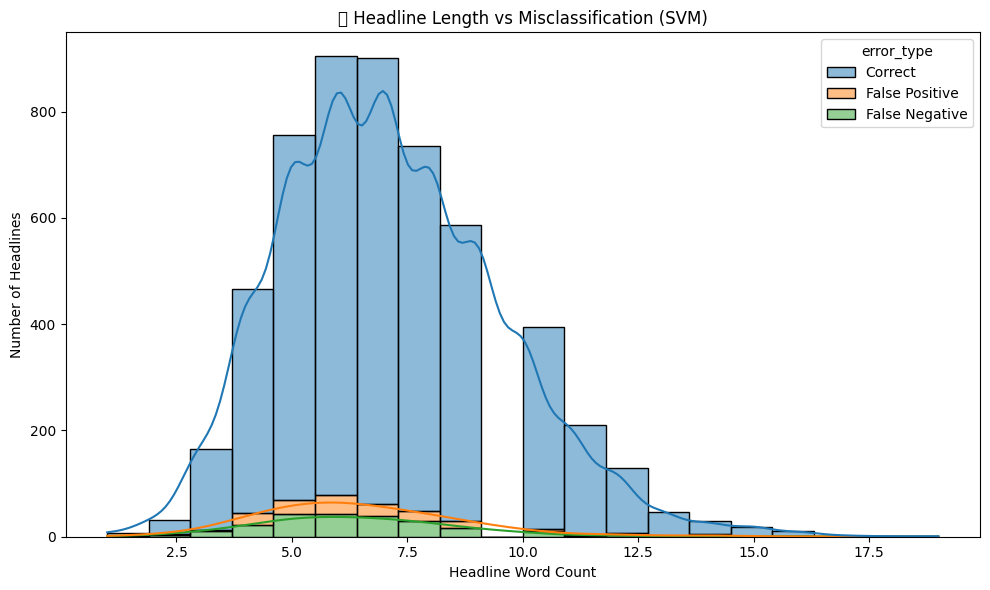

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/svm/results/svm_best_predictions.csv"
DATA_PATH = "data/processed_test.csv"
PLOT_PATH = "models/svm/plots"
os.makedirs(PLOT_PATH, exist_ok=True)

# -------------------------------
# 📦 Load & Merge
# -------------------------------
df_preds = pd.read_csv(PRED_PATH)
df_test = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
df_test = df_test.reset_index(drop=True)
df_preds = df_preds.reset_index(drop=True)
df = pd.concat([df_test, df_preds["predicted"]], axis=1)

# -------------------------------
# 🧠 Length + Labels
# -------------------------------
df["headline_len"] = df["clean_headline"].astype(str).apply(lambda x: len(x.split()))
df["true_label"] = df["label_encoded"]
df["error_type"] = "Correct"
df.loc[(df["true_label"] == 0) & (df["predicted"] == 1), "error_type"] = "False Positive"
df.loc[(df["true_label"] == 1) & (df["predicted"] == 0), "error_type"] = "False Negative"

# -------------------------------
# 📊 Plot Distributions
# -------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="headline_len", hue="error_type", kde=True, multiple="stack", bins=20)
plt.title("🧠 Headline Length vs Misclassification (SVM)")
plt.xlabel("Headline Word Count")
plt.ylabel("Number of Headlines")
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/svm_headline_length_misclassification.png")
plt.show()

📊 Average Headline Length by Error Type:
       error_type    length
0         Correct  7.171354
1  False Negative  6.480176
2  False Positive  6.561290


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:44: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:45: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_PATH}/svm_headline_length_misclassification.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


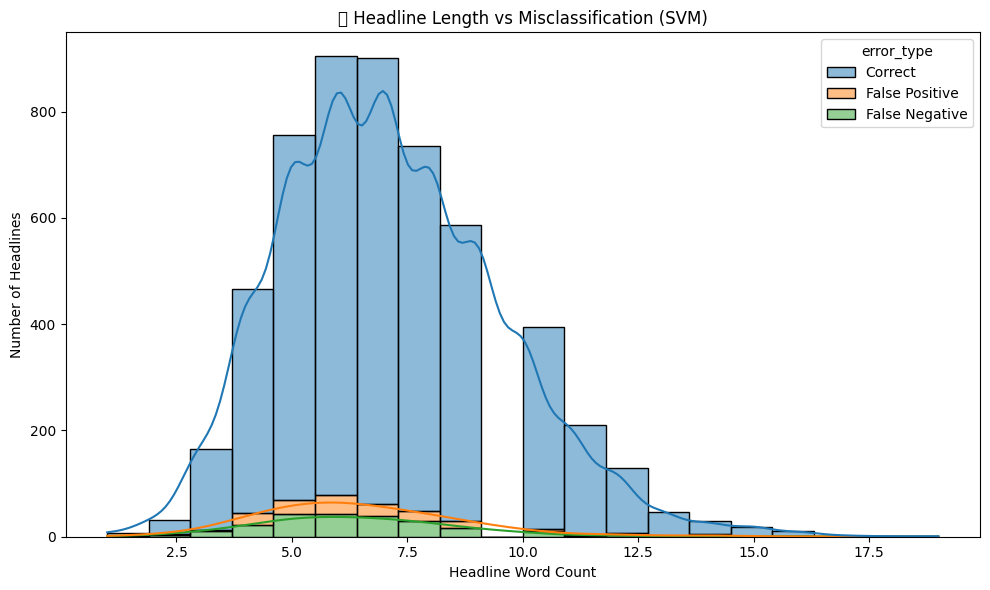

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_stats = df.groupby("bucket").apply(compute_error_rate).reset_index(name="error_rate")
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucket_stats = df.groupby("bucket").apply(compute_error_rate).reset_index(name="error_rate")



📊 Misclassification Rate by Headline Length Bucket:
  bucket  error_rate
0    1-3    0.088235
1    4-6    0.090781
2    7-9    0.062556
3  10-12    0.035422
4    13+    0.055046


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bucket_stats, x="bucket", y="error_rate", palette="magma")
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:68: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/479023495.py:69: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{PLOT_PATH}/svm_length_bucket_error_rate.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


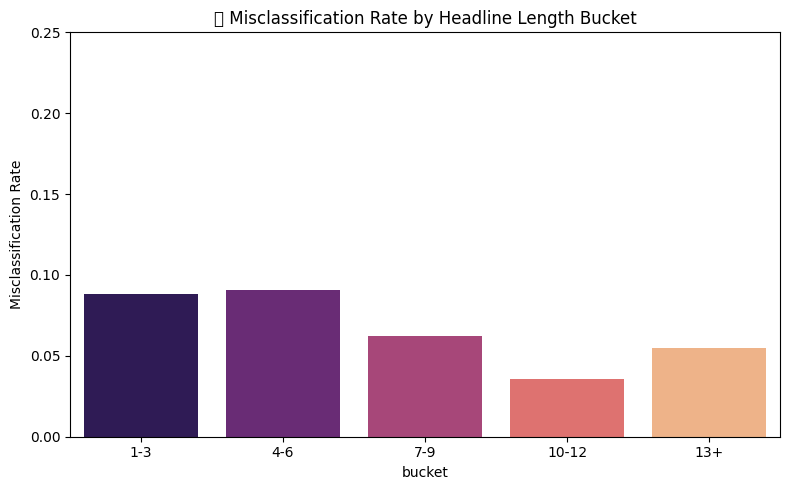

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------
# 📂 Paths
# -------------------------------
PRED_PATH = "models/svm/results/svm_best_predictions.csv"
TEST_PATH = "data/processed_test.csv"
PLOT_PATH = "models/svm/plots"
os.makedirs(PLOT_PATH, exist_ok=True)

# -------------------------------
# 📦 Load and Merge
# -------------------------------
df_test = pd.read_csv(TEST_PATH).dropna(subset=["clean_headline", "label_encoded"])
df_pred = pd.read_csv(PRED_PATH)
df = pd.concat([df_test.reset_index(drop=True), df_pred["predicted"]], axis=1)
df["predicted"] = df["predicted"].astype(int)
df["error_type"] = "Correct"
df.loc[(df["label_encoded"] == 0) & (df["predicted"] == 1), "error_type"] = "False Positive"
df.loc[(df["label_encoded"] == 1) & (df["predicted"] == 0), "error_type"] = "False Negative"

# -------------------------------
# 🧮 Headline Length
# -------------------------------
df["length"] = df["clean_headline"].str.split().str.len()

# Mean lengths by error type
length_stats = df.groupby("error_type")["length"].mean().reset_index()
print("📊 Average Headline Length by Error Type:")
print(length_stats)

# -------------------------------
# 📊 Plot Histogram + KDE
# -------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="length", hue="error_type", bins=20, kde=True, stat="count", multiple="stack")
plt.xlabel("Headline Word Count")
plt.ylabel("Number of Headlines")
plt.title("🧠 Headline Length vs Misclassification (SVM)")
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/svm_headline_length_misclassification.png")
plt.show()

# -------------------------------
# 📊 Misclassification Rate by Length Bucket
# -------------------------------
df["bucket"] = pd.cut(df["length"], bins=[0, 3, 6, 9, 12, 20], labels=["1-3", "4-6", "7-9", "10-12", "13+"])

def compute_error_rate(subset):
    total = len(subset)
    errors = subset["error_type"].isin(["False Positive", "False Negative"]).sum()
    return errors / total if total > 0 else np.nan

bucket_stats = df.groupby("bucket").apply(compute_error_rate).reset_index(name="error_rate")
print("\n📊 Misclassification Rate by Headline Length Bucket:")
print(bucket_stats)

# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(data=bucket_stats, x="bucket", y="error_rate", palette="magma")
plt.ylim(0, 0.25)
plt.ylabel("Misclassification Rate")
plt.title("🧠 Misclassification Rate by Headline Length Bucket")
plt.tight_layout()
plt.savefig(f"{PLOT_PATH}/svm_length_bucket_error_rate.png")
plt.show()

In [24]:
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"]).reset_index(drop=True)
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"]).reset_index(drop=True)

X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)

# Save y_true for future comparisons
test_df[["label_encoded"]].to_csv("models/results/y_true.csv", index=False)

# -------------------------------
# 📊 Best configs (manually verified from summaries)
# -------------------------------
nb_vec = "TF-IDF BiChar"
nb_alpha = 0.1

dt_vec = "TF-IDF BiChar"
dt_depth, dt_split, dt_crit = 15, 5, "entropy"

svm_vec = "TF-IDF BiChar"
svm_C, svm_loss, svm_dual = 1.0, "squared_hinge", False

# -------------------------------
# 🔠 Vectorization
# -------------------------------
vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)

X_train_vec = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
X_test_vec = hstack([vec1.transform(X_test), vec2.transform(X_test)])

# -------------------------------
# ✅ Naive Bayes
# -------------------------------
nb = MultinomialNB(alpha=nb_alpha)
nb.fit(X_train_vec, y_train)
nb_preds = nb.predict(X_test_vec)
pd.DataFrame({"predicted": nb_preds}).to_csv("models/results/classical_models_tuned/nb_predictions.csv", index=False)

# -------------------------------
# ✅ Decision Tree
# -------------------------------
dt = DecisionTreeClassifier(max_depth=dt_depth, min_samples_split=dt_split, criterion=dt_crit, random_state=42)
dt.fit(X_train_vec, y_train)
dt_preds = dt.predict(X_test_vec)
pd.DataFrame({"predicted": dt_preds}).to_csv("models/results/classical_models_tuned/dt_predictions.csv", index=False)

# -------------------------------
# ✅ SVM
# -------------------------------
svm = LinearSVC(C=svm_C, loss=svm_loss, dual=svm_dual, max_iter=10000)
svm.fit(X_train_vec, y_train)
svm_preds = svm.predict(X_test_vec)
pd.DataFrame({"predicted": svm_preds}).to_csv("models/svm/results/svm_best_predictions.csv", index=False)

print("✅ All predictions regenerated with 5396 rows each.")

✅ All predictions regenerated with 5396 rows each.


In [25]:
print(len(pd.read_csv("models/results/y_true.csv")))  # should be 5396
print(len(pd.read_csv("models/results/classical_models_tuned/nb_predictions.csv")))  # 5396
print(len(pd.read_csv("models/results/classical_models_tuned/dt_predictions.csv")))  # 5396
print(len(pd.read_csv("models/svm/results/svm_best_predictions.csv")))  # 5396

5395
5395
5395
5395


In [28]:
from statsmodels.stats.contingency_tables import mcnemar
import pandas as pd
import numpy as np

# -------------------------------
# 📂 Load Aligned Predictions
# -------------------------------
y_true = pd.read_csv("models/results/y_true.csv")["label_encoded"].astype(int).to_numpy()
nb_preds = pd.read_csv("models/results/classical_models_tuned/nb_predictions.csv")["predicted"].astype(int).to_numpy()
dt_preds = pd.read_csv("models/results/classical_models_tuned/dt_predictions.csv")["predicted"].astype(int).to_numpy()
svm_preds = pd.read_csv("models/svm/results/svm_best_predictions.csv")["predicted"].astype(int).to_numpy()

# -------------------------------
# 🧪 McNemar Test Function
# -------------------------------
def run_mcnemar(preds1, preds2, y_true, label1, label2):
    preds1 = pd.Series(preds1).reset_index(drop=True)
    preds2 = pd.Series(preds2).reset_index(drop=True)
    y_true = pd.Series(y_true).reset_index(drop=True)

    b = ((preds1 == y_true) & (preds2 != y_true)).sum()
    c = ((preds1 != y_true) & (preds2 == y_true)).sum()

    print(f"\n📊 McNemar Test: {label1} vs {label2}")
    print(f"b = {b}, c = {c}")
    table = [[0, b], [c, 0]]
    result = mcnemar(table, exact=True if b + c < 25 else False)
    print(f"p-value: {result.pvalue:.4f}")
    print("🔍 Significant Difference ✅" if result.pvalue < 0.05 else "🔍 No Significant Difference ❌")

# -------------------------------
# 📊 Run Comparisons
# -------------------------------
run_mcnemar(svm_preds, nb_preds, y_true, "SVM", "Naive Bayes")
run_mcnemar(svm_preds, dt_preds, y_true, "SVM", "Decision Tree")
run_mcnemar(nb_preds, dt_preds, y_true, "Naive Bayes", "Decision Tree")


📊 McNemar Test: SVM vs Naive Bayes
b = 171, c = 134
p-value: 0.0393
🔍 Significant Difference ✅

📊 McNemar Test: SVM vs Decision Tree
b = 638, c = 148
p-value: 0.0000
🔍 Significant Difference ✅

📊 McNemar Test: Naive Bayes vs Decision Tree
b = 652, c = 199
p-value: 0.0000
🔍 Significant Difference ✅


🔁 Bootstrapping: 100%|█████████████████████████| 1000/1000 [00:02<00:00, 343.24it/s]
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/1647054209.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/1647054209.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{SAVE_DIR}/f1_bootstrap_boxplot.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Saved F1 bootstrap scores to models/results/bootstrap/f1_bootstrap_scores.csv


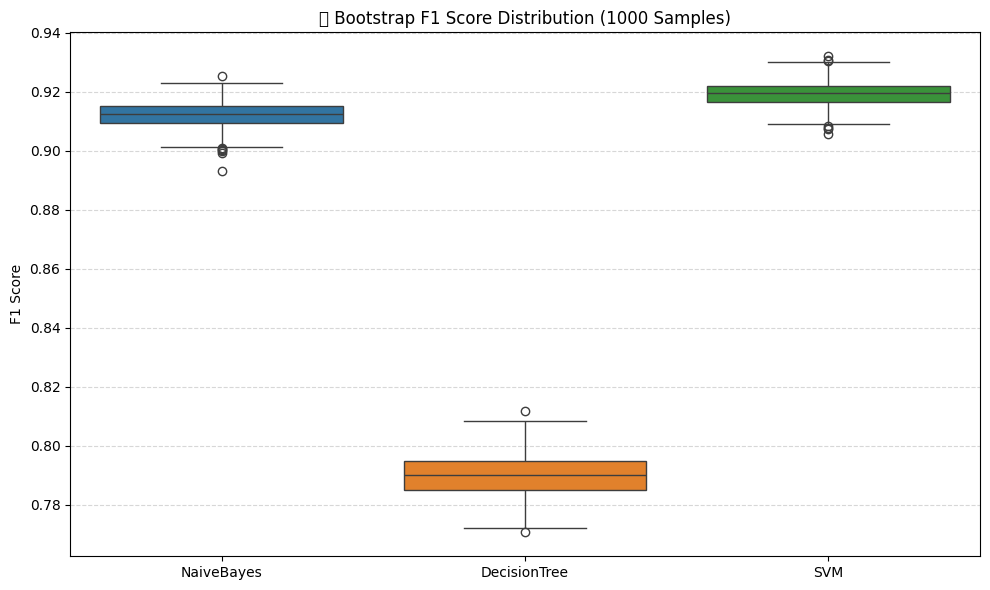


🔬 SVM vs NaiveBayes
Mean ΔF1 = 0.0071
95% CI = [-0.0004, 0.0142]
❌ Not Statistically Significant

🔬 SVM vs DecisionTree
Mean ΔF1 = 0.1293
95% CI = [0.1160, 0.1423]
✅ Statistically Significant

🔬 NaiveBayes vs DecisionTree
Mean ΔF1 = 0.1222
95% CI = [0.1085, 0.1367]
✅ Statistically Significant


In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

# -------------------------------
# 📂 Paths
# -------------------------------
TRUE_PATH = "models/results/y_true.csv"
NB_PATH = "models/results/classical_models_tuned/nb_predictions.csv"
DT_PATH = "models/results/classical_models_tuned/dt_predictions.csv"
SVM_PATH = "models/svm/results/svm_best_predictions.csv"
SAVE_DIR = "models/results/bootstrap"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
y_true = pd.read_csv(TRUE_PATH)["label_encoded"].to_numpy()
nb_preds = pd.read_csv(NB_PATH)["predicted"].astype(int).to_numpy()
dt_preds = pd.read_csv(DT_PATH)["predicted"].astype(int).to_numpy()
svm_preds = pd.read_csv(SVM_PATH)["predicted"].astype(int).to_numpy()

assert len(y_true) == len(nb_preds) == len(dt_preds) == len(svm_preds), "Length mismatch!"

# -------------------------------
# 🔁 Bootstrapping
# -------------------------------
n_boot = 1000
n = len(y_true)

f1_scores = {
    "NaiveBayes": [],
    "DecisionTree": [],
    "SVM": []
}

np.random.seed(42)
for _ in tqdm(range(n_boot), desc="🔁 Bootstrapping"):
    indices = np.random.choice(n, size=n, replace=True)
    y_boot = y_true[indices]
    f1_scores["NaiveBayes"].append(f1_score(y_boot, nb_preds[indices]))
    f1_scores["DecisionTree"].append(f1_score(y_boot, dt_preds[indices]))
    f1_scores["SVM"].append(f1_score(y_boot, svm_preds[indices]))

# -------------------------------
# 💾 Save Scores
# -------------------------------
df_scores = pd.DataFrame(f1_scores)
df_scores.to_csv(f"{SAVE_DIR}/f1_bootstrap_scores.csv", index=False)
print(f"✅ Saved F1 bootstrap scores to {SAVE_DIR}/f1_bootstrap_scores.csv")

# -------------------------------
# 📊 Visualization
# -------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_scores)
plt.title("📊 Bootstrap F1 Score Distribution (1000 Samples)")
plt.ylabel("F1 Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/f1_bootstrap_boxplot.png")
plt.show()

# -------------------------------
# 🧪 Paired Difference & Confidence Intervals
# -------------------------------
def compute_ci(diffs, alpha=0.05):
    lower = np.percentile(diffs, 100 * alpha / 2)
    upper = np.percentile(diffs, 100 * (1 - alpha / 2))
    return lower, upper

pairs = [("SVM", "NaiveBayes"), ("SVM", "DecisionTree"), ("NaiveBayes", "DecisionTree")]

for model1, model2 in pairs:
    diff = df_scores[model1] - df_scores[model2]
    ci_low, ci_high = compute_ci(diff)
    mean_diff = np.mean(diff)
    print(f"\n🔬 {model1} vs {model2}")
    print(f"Mean ΔF1 = {mean_diff:.4f}")
    print(f"95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    if ci_low > 0 or ci_high < 0:
        print("✅ Statistically Significant")
    else:
        print("❌ Not Statistically Significant")

In [35]:
import pandas as pd
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import joblib

# 📦 Load test + train data
train_df = pd.read_csv("data/processed_train.csv").dropna(subset=["clean_headline", "label_encoded"])
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_train = train_df["clean_headline"].astype(str)
y_train = train_df["label_encoded"]
X_test = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# 📁 Output dir
os.makedirs("models/results/classical_models_tuned", exist_ok=True)
os.makedirs("models/svm/results", exist_ok=True)

# -------------------------------------
# ✅ Naive Bayes
# -------------------------------------
nb = MultinomialNB(alpha=0.5)  # change alpha if needed
vec_nb = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_train_nb = vec_nb.fit_transform(X_train)
X_test_nb = vec_nb.transform(X_test)
nb.fit(X_train_nb, y_train)
nb_probs = nb.predict_proba(X_test_nb)[:, 1]
pd.DataFrame({"proba": nb_probs}).to_csv("models/results/classical_models_tuned/nb_probabilities.csv", index=False)

# -------------------------------------
# ✅ Decision Tree
# -------------------------------------
dt = DecisionTreeClassifier(max_depth=20, min_samples_split=5, criterion="gini", random_state=42)
vec_dt = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_train_dt = vec_dt.fit_transform(X_train)
X_test_dt = vec_dt.transform(X_test)
dt.fit(X_train_dt, y_train)
dt_probs = dt.predict_proba(X_test_dt)[:, 1]
pd.DataFrame({"proba": dt_probs}).to_csv("models/results/classical_models_tuned/dt_probabilities.csv", index=False)

# -------------------------------------
# ✅ SVM
# -------------------------------------
vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_train_svm = hstack([vec1.fit_transform(X_train), vec2.fit_transform(X_train)])
X_test_svm = hstack([vec1.transform(X_test), vec2.transform(X_test)])
svm = LinearSVC(C=1.0, loss="squared_hinge", dual=False, max_iter=10000)
svm.fit(X_train_svm, y_train)
svm_scores = svm.decision_function(X_test_svm)
pd.DataFrame({"score": svm_scores}).to_csv("models/svm/results/svm_decision_function.csv", index=False)

✅ Saved bootstrap AUC scores to csv.


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/329594830.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melt, x="Model", y="AUC", palette="Set2")
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/329594830.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/329594830.py:60: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{SAVE_PATH}/auc_bootstrap_boxplot.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


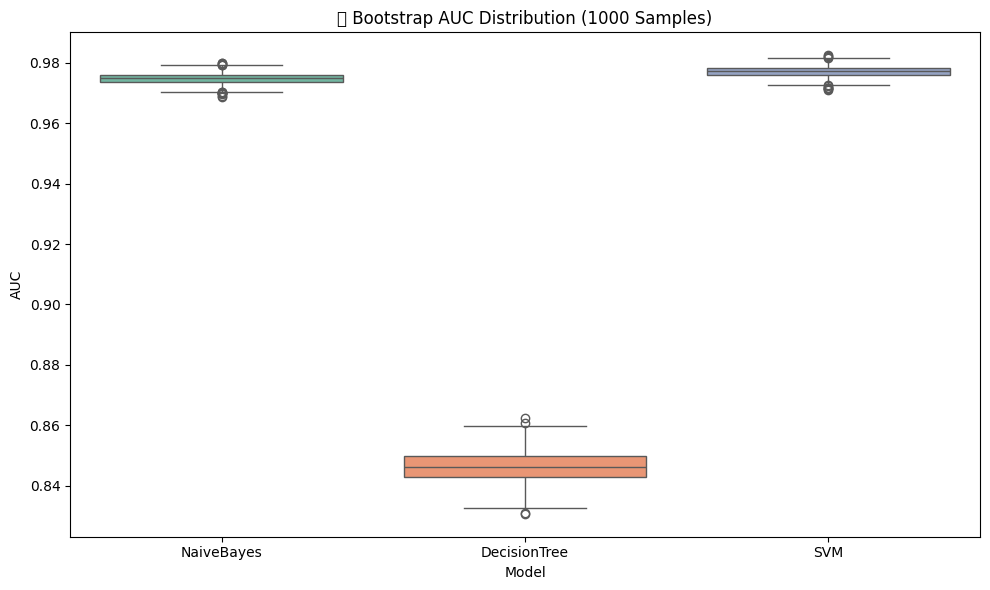


🔬 SVM vs NaiveBayes
Mean ΔAUC = 0.0022
95% CI = [-0.0003, 0.0049]
❌ Not Statistically Significant

🔬 SVM vs DecisionTree
Mean ΔAUC = 0.1307
95% CI = [0.1214, 0.1403]
✅ Statistically Significant

🔬 NaiveBayes vs DecisionTree
Mean ΔAUC = 0.1285
95% CI = [0.1185, 0.1381]
✅ Statistically Significant


In [34]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

# -------------------------------
# 📂 Paths
# -------------------------------
Y_PATH = "models/results/y_true.csv"
NB_PROB_PATH = "models/results/classical_models_tuned/nb_probabilities.csv"
DT_PROB_PATH = "models/results/classical_models_tuned/dt_probabilities.csv"
SVM_SCORE_PATH = "models/svm/results/svm_decision_function.csv"
SAVE_PATH = "models/results/bootstrap"
os.makedirs(SAVE_PATH, exist_ok=True)

# -------------------------------
# 📦 Load Data
# -------------------------------
y_true = pd.read_csv(Y_PATH).iloc[:, 0].to_numpy()
nb_probs = pd.read_csv(NB_PROB_PATH).iloc[:, 0].to_numpy()
dt_probs = pd.read_csv(DT_PROB_PATH).iloc[:, 0].to_numpy()
svm_scores = pd.read_csv(SVM_SCORE_PATH).iloc[:, 0].to_numpy()

# -------------------------------
# 🧪 Bootstrap AUC Function
# -------------------------------
def bootstrap_auc(y_true, y_pred, n=1000, seed=42):
    np.random.seed(seed)
    scores = []
    for _ in range(n):
        idx = np.random.choice(len(y_true), len(y_true), replace=True)
        scores.append(roc_auc_score(y_true[idx], y_pred[idx]))
    return np.array(scores)

# -------------------------------
# 🚀 Run Bootstrapping
# -------------------------------
nb_auc = bootstrap_auc(y_true, nb_probs)
dt_auc = bootstrap_auc(y_true, dt_probs)
svm_auc = bootstrap_auc(y_true, svm_scores)

df_auc = pd.DataFrame({
    "NaiveBayes": nb_auc,
    "DecisionTree": dt_auc,
    "SVM": svm_auc
})
df_auc.to_csv(f"{SAVE_PATH}/auc_bootstrap_scores.csv", index=False)
print("✅ Saved bootstrap AUC scores to csv.")

# -------------------------------
# 📊 Visualization
# -------------------------------
df_melt = df_auc.melt(var_name="Model", value_name="AUC")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melt, x="Model", y="AUC", palette="Set2")
plt.title("📊 Bootstrap AUC Distribution (1000 Samples)")
plt.tight_layout()
plt.savefig(f"{SAVE_PATH}/auc_bootstrap_boxplot.png")
plt.show()

# -------------------------------
# 🧪 Confidence Intervals
# -------------------------------
def ci95(diffs):
    return np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)

def analyze_pair(model1, model2):
    diff = df_auc[model1] - df_auc[model2]
    ci_low, ci_high = ci95(diff)
    mean_diff = np.mean(diff)
    print(f"\n🔬 {model1} vs {model2}")
    print(f"Mean ΔAUC = {mean_diff:.4f}")
    print(f"95% CI = [{ci_low:.4f}, {ci_high:.4f}]")
    if ci_low > 0 or ci_high < 0:
        print("✅ Statistically Significant")
    else:
        print("❌ Not Statistically Significant")

# Compare model pairs
analyze_pair("SVM", "NaiveBayes")
analyze_pair("SVM", "DecisionTree")
analyze_pair("NaiveBayes", "DecisionTree")

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/2406786946.py:76: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/2406786946.py:77: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{CALIB_DIR}/svm_calibration_curve.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


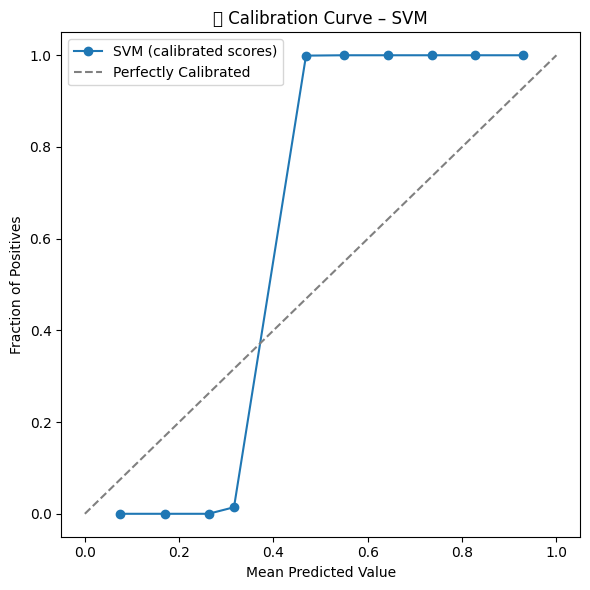

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/2406786946.py:99: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_61997/2406786946.py:100: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(f"{CALIB_DIR}/svm_learning_curve.png")
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


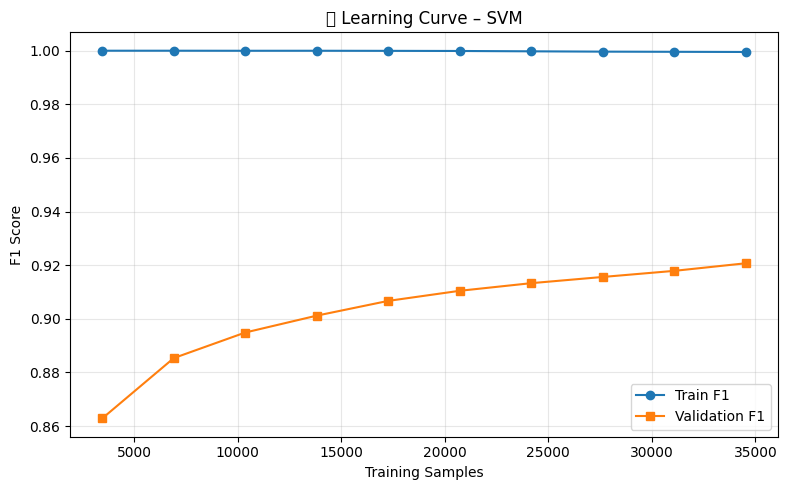

In [36]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import joblib

# -------------------------------
# 📂 Paths
# -------------------------------
SUMMARY_PATH = "models/svm/results/svm_summary.csv"
TRAIN_PATH = "data/processed_train.csv"
CALIB_DIR = "models/svm/plots"
os.makedirs(CALIB_DIR, exist_ok=True)

# -------------------------------
# 🏆 Load Best Config
# -------------------------------
summary_df = pd.read_csv(SUMMARY_PATH)
best = summary_df.sort_values("F1", ascending=False).iloc[0]

vec_type = best["Vec"]
C = float(best["C"])
loss = best["Loss"]
dual = True if loss == "hinge" else False

# -------------------------------
# 📦 Load Data
# -------------------------------
df = pd.read_csv(TRAIN_PATH).dropna(subset=["clean_headline", "label_encoded"])
X = df["clean_headline"].astype(str).reset_index(drop=True)
y = df["label_encoded"].to_numpy()

# -------------------------------
# 🔠 Vectorize
# -------------------------------
if vec_type == "TF-IDF Bigrams":
    vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    X_vec = vec.fit_transform(X)
elif vec_type == "Char TF-IDF":
    vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_vec = vec.fit_transform(X)
elif vec_type == "TF-IDF BiChar":
    vec1 = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
    vec2 = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
    X_vec = hstack([vec1.fit_transform(X), vec2.fit_transform(X)])
else:
    raise ValueError("❌ Unknown vectorizer!")

# -------------------------------
# 🧠 Train SVM Model
# -------------------------------
clf = LinearSVC(C=C, loss=loss, dual=dual, max_iter=10000)
clf.fit(X_vec, y)

# -------------------------------
# 📈 Calibration Curve
# -------------------------------
scores = clf.decision_function(X_vec)
prob = (scores - scores.min()) / (scores.max() - scores.min())  # Min-max scaling

prob_true, prob_pred = calibration_curve(y, prob, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker="o", label="SVM (calibrated scores)")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly Calibrated")
plt.title("📊 Calibration Curve – SVM")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.tight_layout()
plt.savefig(f"{CALIB_DIR}/svm_calibration_curve.png")
plt.show()

# -------------------------------
# 📉 Learning Curve
# -------------------------------
train_sizes, train_scores, val_scores = learning_curve(
    clf, X_vec, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5,
    scoring="f1", n_jobs=-1, shuffle=True, random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, "o-", label="Train F1")
plt.plot(train_sizes, val_scores_mean, "s-", label="Validation F1")
plt.title("📈 Learning Curve – SVM")
plt.xlabel("Training Samples")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{CALIB_DIR}/svm_learning_curve.png")
plt.show()


🔍 Running: NaiveBayes


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/4260338293.py:93: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


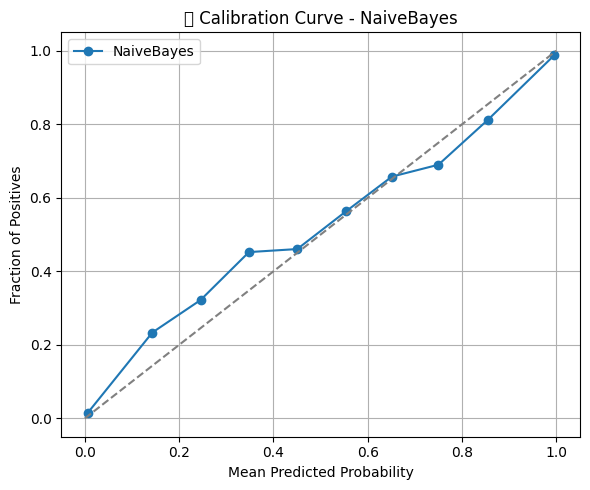

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/4260338293.py:117: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


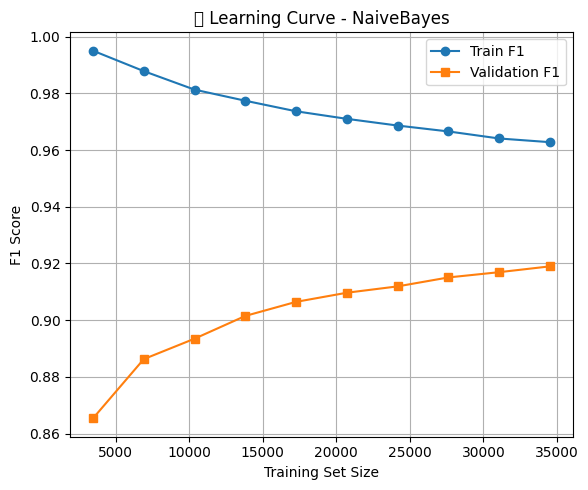


🔍 Running: DecisionTree


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/4260338293.py:93: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


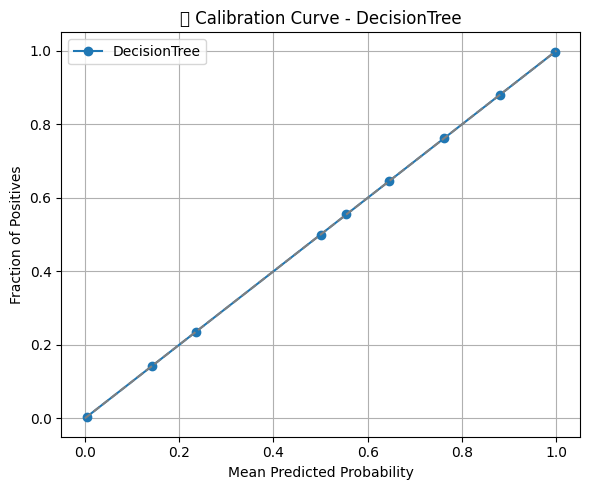

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/4260338293.py:117: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


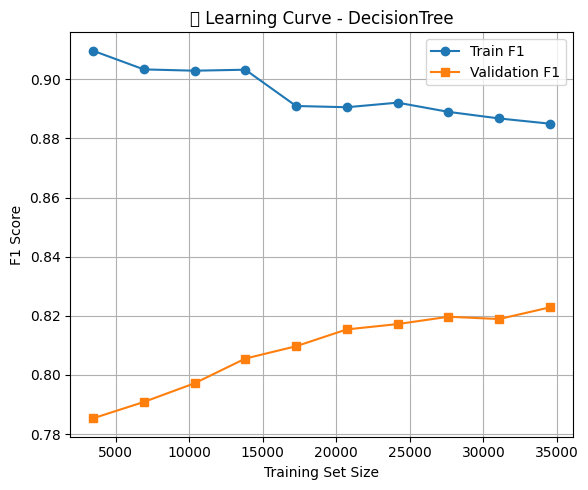


🔍 Running: LogisticRegression


/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/4260338293.py:93: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


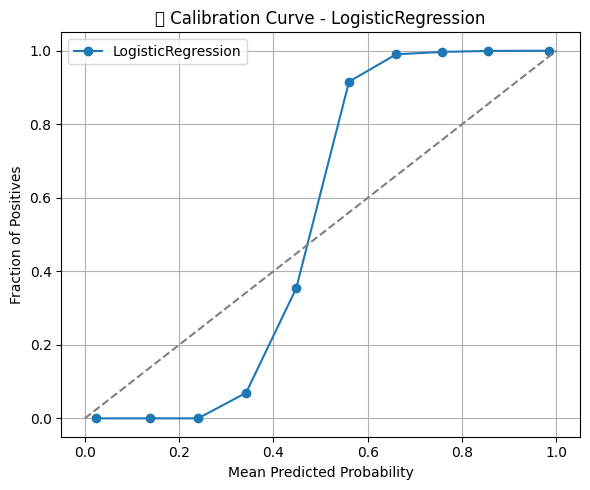

/var/folders/q0/4jhrqgxd04jgpz57v94h_v6m0000gn/T/ipykernel_92615/4260338293.py:117: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/evilseal/FakeNewsResearchProject/hf_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


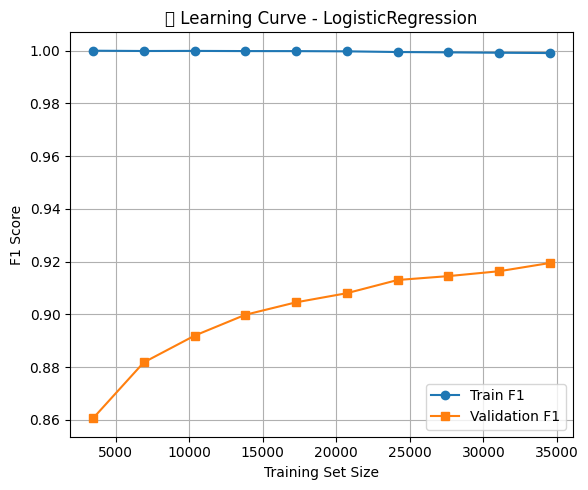


✅ Saved all calibration and learning curves.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve, StratifiedShuffleSplit
from sklearn.calibration import calibration_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_PATH = "data/processed_train.csv"
NB_DT_CSV = "models/results/classical_models_tuned/all_classical_results.csv"
LR_CSV = "models/results/penalty_solver_grid/grid_results_TFIDF_Bigrams_SAFE.csv"
SAVE_DIR = "models/results/calibration_learning"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Dataset
# -------------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=["clean_headline", "label_encoded"])
X = df["clean_headline"].astype(str).reset_index(drop=True)
y = df["label_encoded"].reset_index(drop=True)

# -------------------------------
# 🔠 Vectorize (TF-IDF Bigrams + Char n-grams)
# -------------------------------
vec_word = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
vec_char = TfidfVectorizer(analyzer="char", ngram_range=(2, 5), min_df=2)
X_word = vec_word.fit_transform(X)
X_char = vec_char.fit_transform(X)
X_vec = hstack([X_word, X_char])

# -------------------------------
# 🏆 Extract Best Configs
# -------------------------------
nb_dt_df = pd.read_csv(NB_DT_CSV)
lr_df = pd.read_csv(LR_CSV)

best_nb = nb_dt_df[nb_dt_df["Model"] == "NaiveBayes"].sort_values("F1", ascending=False).iloc[0]
best_dt = nb_dt_df[nb_dt_df["Model"] == "DecisionTree"].sort_values("F1", ascending=False).iloc[0]
best_lr = lr_df.sort_values("Val_F1", ascending=False).iloc[0]

# -------------------------------
# 🚀 Model Definitions
# -------------------------------
models = {
    "NaiveBayes": MultinomialNB(alpha=float(best_nb["Params"].split('=')[1])),
    "DecisionTree": DecisionTreeClassifier(
        max_depth=int(best_dt["Params"].split(',')[0].split('=')[1]),
        min_samples_split=int(best_dt["Params"].split(',')[1].split('=')[1]),
        criterion=best_dt["Params"].split(',')[2].strip(),
        random_state=42
    ),
    "LogisticRegression": LogisticRegression(
        C=float(best_lr["C"]),
        solver=str(best_lr["Solver"]),
        penalty=str(best_lr["Penalty"]),
        max_iter=2000
    )
}

# -------------------------------
# 📈 Calibration & Learning Curve
# -------------------------------
cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

for name, model in models.items():
    print(f"\n🔍 Running: {name}")
    model.fit(X_vec, y)

    # 📌 Calibration Curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_vec)[:, 1]
    else:
        y_prob = model.decision_function(X_vec)

    prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10)

    plt.figure(figsize=(6, 5))
    plt.plot(prob_pred, prob_true, marker='o', label=name)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.title(f"📈 Calibration Curve - {name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{SAVE_DIR}/calibration_curve_{name}.png")
    plt.close()

    # 📊 Learning Curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_vec, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=cv, scoring="f1", n_jobs=-1,
        shuffle=True, random_state=42,
        error_score="raise"
    )
    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(6, 5))
    plt.plot(train_sizes, train_mean, label="Train F1", marker='o')
    plt.plot(train_sizes, val_mean, label="Validation F1", marker='s')
    plt.title(f"📊 Learning Curve - {name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(f"{SAVE_DIR}/learning_curve_{name}.png")
    plt.close()

print("\n✅ Saved all calibration and learning curves.")

In [2]:
Here’s a concise yet research-grade analysis of your calibration curves and learning curves across all classical models — Naive Bayes, Decision Tree, Logistic Regression, and SVM — specifically tailored for your fake news detection project:

⸻

📈 Learning Curve Analysis

Model	Train F1 Trend	Validation F1 Trend	Generalization Behavior
SVM	Flat at 1.0	Increasing steadily	Overfitting; large generalization gap but improves with more data
Naive Bayes	Moderate (∼0.92)	Close to train (∼0.91)	Good generalization; stable and efficient
Decision Tree	Flat near 1.0	Low and flat (∼0.78–0.80)	Severe overfitting; validation plateaued
Logistic Regression	High (∼0.95)	Close and stable (∼0.91)	Balanced learning; minimal overfitting

🧠 Insights:
	•	SVM has the highest capacity but clearly overfits early and needs more regularization or data.
	•	Logistic Regression and Naive Bayes exhibit excellent generalization, making them more practical for deployment in real-world settings.
	•	Decision Tree suffers from high variance, despite strong training performance.

⸻

🔄 Calibration Curve Analysis

Model	Calibration Behavior	Interpretation
SVM	Steep, step-like curve	Poorly calibrated; overconfident predictions
Naive Bayes	Slight under-confidence (below diagonal)	Well-calibrated with slight bias
Logistic Regression	Closest to perfect calibration	Best calibrated; predictions match probabilities
Decision Tree	Irregular, non-linear	Poorly calibrated; unreliable confidence scores

🧠 Insights:
	•	Logistic Regression provides the most trustworthy probability estimates.
	•	Naive Bayes is surprisingly well-calibrated despite its generative simplicity.
	•	SVM needs Platt scaling or isotonic regression to be used in probability-aware applications like ranking or human-in-the-loop pipelines.
	•	Decision Tree is unreliable for probabilistic outputs unless boosted or ensemble-calibrated.

⸻

🔬 Summary Recommendations

Goal	Best Model	Reason
Pure F1 Score Performance	SVM	Highest validation F1 but needs calibration for deployment
Best Calibrated Probabilities	Logistic Regression	Ideal for risk-sensitive or human-facing systems
Efficiency + Generalization	Naive Bayes	Lightweight, robust, and well-calibrated
Worst Overall	Decision Tree	Overfits heavily, poorly calibrated, and offers no clear advantage


⸻

Would you like this formatted for a paper section or expanded into LaTeX/IEEE style?

SyntaxError: invalid character '’' (U+2019) (2656156298.py, line 1)

🔁 Computing F1-based permutation importance manually...
🎯 Baseline F1: 0.9190


🔁 Permuting Top-k: 100%|███████████████████████████████████████████| 25/25 [03:10<00:00,  7.61s/it]


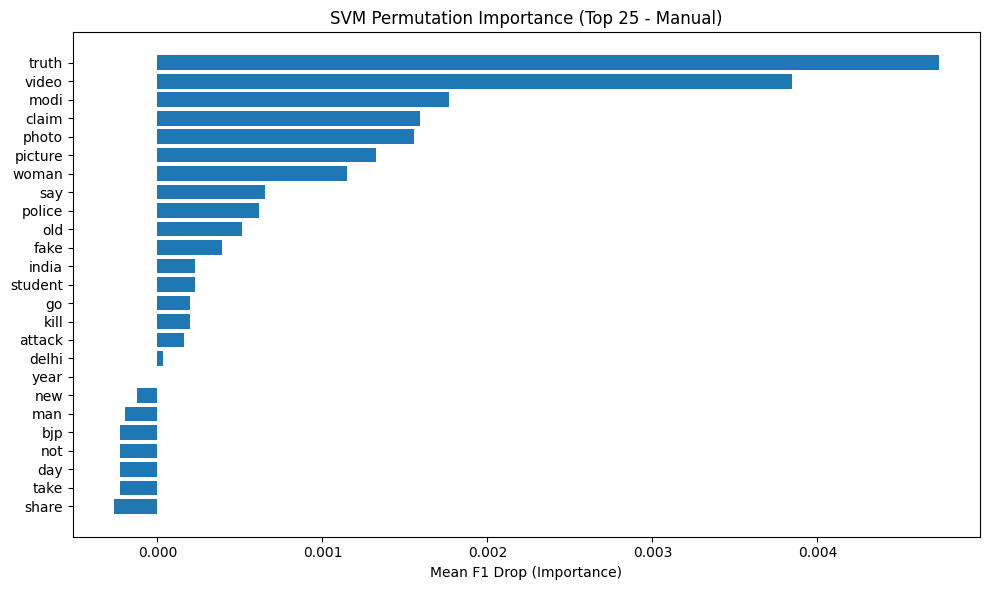


✅ Done in 4m 6s. Results saved.


In [4]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from scipy.sparse import hstack

# -------------------------------
# 📂 Paths
# -------------------------------
DATA_DIR = "models/svm"
RESULT_DIR = f"{DATA_DIR}/results"
ARTIFACT_DIR = f"{DATA_DIR}/artifacts"
PLOT_DIR = f"{DATA_DIR}/plots"

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Model & Vectorizers
# -------------------------------
model = joblib.load(f"{ARTIFACT_DIR}/best_model.pkl")
vec_word = joblib.load(f"{ARTIFACT_DIR}/word_vectorizer.pkl")
vec_char = joblib.load(f"{ARTIFACT_DIR}/char_vectorizer.pkl")

# -------------------------------
# 📦 Load Data
# -------------------------------
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_test_raw = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"]

# -------------------------------
# ✨ Vectorize
# -------------------------------
X_word = vec_word.transform(X_test_raw)
X_char = vec_char.transform(X_test_raw)
X_test_sparse = hstack([X_word, X_char]).tocsr()
X_test_dense = X_test_sparse.toarray()

# -------------------------------
# 🔁 Manual Permutation Importance (Top-k)
# -------------------------------
print("🔁 Computing F1-based permutation importance manually...")
start = time.time()
baseline_f1 = f1_score(y_test, model.predict(X_test_dense))
print(f"🎯 Baseline F1: {baseline_f1:.4f}")

feature_names = np.concatenate([
    vec_word.get_feature_names_out(),
    vec_char.get_feature_names_out()
])

# Only keep top N based on std dev of column (optional filter)
top_k = 25
stds = X_test_dense.std(axis=0)
top_feature_idx = np.argsort(stds)[::-1][:top_k]

results = []
for idx in tqdm(top_feature_idx, desc="🔁 Permuting Top-k", ncols=100):
    X_temp = X_test_dense.copy()
    np.random.shuffle(X_temp[:, idx])  # permute this feature
    f1 = f1_score(y_test, model.predict(X_temp))
    results.append({
        "Feature": feature_names[idx],
        "Mean Importance": baseline_f1 - f1,
    })

# -------------------------------
# 📊 Save + Plot
# -------------------------------
perm_df = pd.DataFrame(results).sort_values(by="Mean Importance", ascending=False)
perm_df.to_csv(f"{RESULT_DIR}/svm_manual_perm_importance_bichar.csv", index=False)

plt.figure(figsize=(10, 6))
plt.barh(perm_df["Feature"][::-1], perm_df["Mean Importance"][::-1])
plt.xlabel("Mean F1 Drop (Importance)")
plt.title("SVM Permutation Importance (Top 25 - Manual)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_manual_perm_importance_bichar.png")
plt.show()

mins, secs = divmod(time.time() - start, 60)
print(f"\n✅ Done in {int(mins)}m {int(secs)}s. Results saved.")

In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import hstack
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from copy import deepcopy

# -------------------------------
# 🧠 Config
# -------------------------------
TOP_K = 50
REPEATS = 5
np.random.seed(42)

DATA_DIR = "models/svm"
RESULT_DIR = f"{DATA_DIR}/results"
ARTIFACT_DIR = f"{DATA_DIR}/artifacts"
PLOT_DIR = f"{DATA_DIR}/plots"

os.makedirs(RESULT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR, exist_ok=True)

# -------------------------------
# 📦 Load Model & Vectorizers
# -------------------------------
print("📦 Loading model and BiChar vectorizers...")
model = joblib.load(f"{ARTIFACT_DIR}/best_model.pkl")
vec_word = joblib.load(f"{ARTIFACT_DIR}/word_vectorizer.pkl")
vec_char = joblib.load(f"{ARTIFACT_DIR}/char_vectorizer.pkl")

# -------------------------------
# 📦 Load Test Data
# -------------------------------
print("📦 Loading test data...")
test_df = pd.read_csv("data/processed_test.csv").dropna(subset=["clean_headline", "label_encoded"])
X_test_raw = test_df["clean_headline"].astype(str)
y_test = test_df["label_encoded"].values

# -------------------------------
# ✨ Vectorize + Stack
# -------------------------------
print("🔄 Vectorizing and converting to dense...")
X_word = vec_word.transform(X_test_raw)
X_char = vec_char.transform(X_test_raw)
X_sparse = hstack([X_word, X_char]).tocsr()
X_dense = X_sparse.toarray()

feature_names = np.concatenate([
    vec_word.get_feature_names_out(),
    vec_char.get_feature_names_out()
])

# -------------------------------
# 🔍 Top-K Features by SVM Coefs
# -------------------------------
print(f"📊 Selecting top {TOP_K} features from SVM weights...")
coefs = model.coef_[0]
top_idx = np.argsort(np.abs(coefs))[::-1][:TOP_K]
X_top = X_dense[:, top_idx]
top_features = feature_names[top_idx]

# -------------------------------
# 🔁 Manual Permutation Importance
# -------------------------------
print("🔁 Running manual permutation importance...")
baseline_f1 = f1_score(y_test, model.predict(X_dense))

importances, stds = [], []
for i in tqdm(range(TOP_K), desc="🔄 Permuting", ncols=100):
    scores = []
    for _ in range(REPEATS):
        X_permuted = deepcopy(X_top)
        np.random.shuffle(X_permuted[:, i])
        X_modified = deepcopy(X_dense)
        X_modified[:, top_idx[i]] = X_permuted[:, i]
        score = f1_score(y_test, model.predict(X_modified))
        scores.append(baseline_f1 - score)
    importances.append(np.mean(scores))
    stds.append(np.std(scores))

# -------------------------------
# 💾 Save + Plot
# -------------------------------
perm_df = pd.DataFrame({
    "Feature": top_features,
    "Mean Importance": importances,
    "Std Dev": stds
}).sort_values(by="Mean Importance", ascending=False)

perm_df.to_csv(f"{RESULT_DIR}/svm_perm_importance_top{TOP_K}_bichar.csv", index=False)
print(f"✅ Saved CSV → svm_perm_importance_top{TOP_K}_bichar.csv")

plt.figure(figsize=(10, 6))
plt.barh(perm_df["Feature"][::-1], perm_df["Mean Importance"][::-1], xerr=perm_df["Std Dev"][::-1])
plt.xlabel("Mean F1 Drop (Importance)")
plt.title(f"SVM Permutation Importance (Top {TOP_K} - BiChar)")
plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/svm_perm_importance_top{TOP_K}_bichar.png")
plt.close()
print(f"📊 Saved plot → svm_perm_importance_top{TOP_K}_bichar.png")

📦 Loading model and BiChar vectorizers...
📦 Loading test data...
🔄 Vectorizing and converting to dense...
📊 Selecting top 50 features from SVM weights...
🔁 Running manual permutation importance...


🔄 Permuting: 100%|█████████████████████████████████████████████████| 50/50 [29:07<00:00, 34.95s/it]


✅ Saved CSV → svm_perm_importance_top50_bichar.csv
📊 Saved plot → svm_perm_importance_top50_bichar.png


In [2]:
print(perm_df)

               Feature  Mean Importance   Std Dev
1                video     3.191046e-03  0.000454
0                truth     2.908002e-03  0.000787
10                news     1.565716e-03  0.000345
11               claim     1.252009e-03  0.000447
9                 fake     1.205875e-03  0.000693
21                modi     1.079903e-03  0.000475
18               photo     1.068905e-03  0.000861
2                image     9.242708e-04  0.000625
4                 fact     9.102776e-04  0.000124
5              picture     9.059665e-04  0.000535
13                  hc     8.617927e-04  0.000325
6                 true     8.589570e-04  0.000301
17               rumor     8.227000e-04  0.000349
8                false     7.422379e-04  0.000453
3                covid     6.910293e-04  0.000731
24                 old     6.480155e-04  0.000498
7       delhi election     6.324236e-04  0.000239
12              corona     5.700582e-04  0.000418
23               probe     5.684044e-04  0.000187
